<a href="https://colab.research.google.com/github/t-perniola/KAR-GRBs/blob/main/KAN_Regressor_GRBs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="intro"></a>
# **KAN Regressor**
Predict the per-bin expected probability distribution of photon counts, combining temporal information with satellite info/metadata (e.g., coordinates, altitudes, position), verifying whether the predicted distribution aligns with the theoretical or expected probability distribution.

## **Importing** libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Inspecting** the data
Let's import our orientation dataframe, that will mainly contain satellite metadata.

In [2]:
# Loading dataset and printing shape
satellite_data_original = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Internship + Thesis/data/satellite_data_mod.xlsx')
print(f"Satellite dataset shape: {satellite_data_original.shape}")

Satellite dataset shape: (5761, 9)


In [3]:
satellite_data_original.head()

TypeOrientationsGalactic     timestamp      x_lat      x_lon      z_lat  \
0                       OG  1.835487e+09  59.274529  22.415898 -30.725471   
1                       OG  1.835487e+09  58.504010  22.732337 -31.495990   
2                       OG  1.835487e+09  57.732736  23.048787 -32.267264   
3                       OG  1.835487e+09  56.960731  23.365378 -33.039269   
4                       OG  1.835487e+09  56.188017  23.682244 -33.811983   

   z_lon(galactic)  altitude(km)  Earth_lat  Earth_lon  
0        22.415898    530.222097  -0.000190  27.047042  
1        22.732337    530.219997  -0.000184  27.927215  
2        23.048787    530.216960  -0.000177  28.807377  
3        23.365378    530.212986  -0.000171  29.687529  
4        23.682244    530.208077  -0.000165  30.567670

In [4]:
satellite_data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5761 entries, 0 to 5760
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TypeOrientationsGalactic  5761 non-null   object 
 1   timestamp                 5761 non-null   float64
 2   x_lat                     5761 non-null   float64
 3   x_lon                     5761 non-null   float64
 4   z_lat                     5761 non-null   float64
 5   z_lon(galactic)           5761 non-null   float64
 6   altitude(km)              5761 non-null   float64
 7   Earth_lat                 5761 non-null   float64
 8   Earth_lon                 5761 non-null   float64
dtypes: float64(8), object(1)
memory usage: 405.2+ KB


We can drop the Type of Orientations Galactic column, since it does not provide useful information.

In [5]:
satellite_data_original = satellite_data_original.drop(columns=['TypeOrientationsGalactic'])
satellite_data_original.rename(columns={'z_lon(galactic)':'z_lon'}, inplace=True)

Visualizing columns

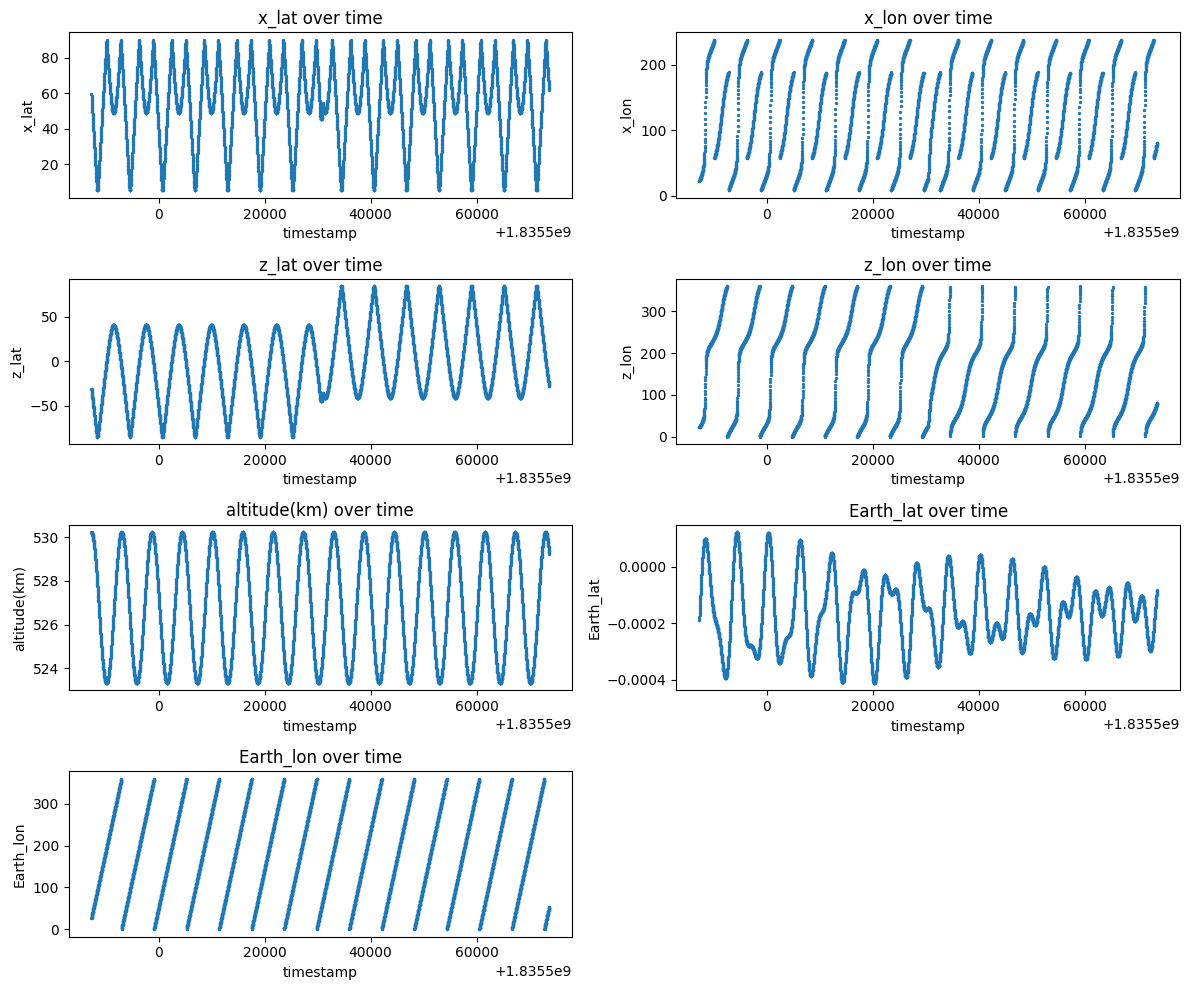

In [6]:
# Get the list of columns to plot
cols_to_plot = satellite_data_original.columns.drop(['timestamp'])
n_cols_to_plot = len(cols_to_plot)
ncols = 2
nrows = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 2.5)) # Adjust figure height based on nrows

for i, feature_col in enumerate(cols_to_plot):
  row, col = divmod(i, ncols)  # Compute subplot position
  satellite_data_original.plot.scatter(
        x='timestamp', y=feature_col, s=2, title=f'{feature_col} over time', ax=ax[row, col]
    )

# Hide any unused subplots
for i in range(n_cols_to_plot, nrows * ncols):
    row, col = divmod(i, ncols)
    fig.delaxes(ax[row, col])


plt.tight_layout()
plt.show()

> We can easily spot how all of the feature columns show some kind of obscillatory pattern, due to the satellite **orbit motion**, that repeats itself every *N* timestamps.

Loading other data

In [7]:
# Loading time and rate arrays
time_array_15s = np.load('/content/drive/MyDrive/Colab Notebooks/Internship + Thesis/data/time_array.npy')
total_counts_15s = np.load('/content/drive/MyDrive/Colab Notebooks/Internship + Thesis/data/total_counts.npy')
total_rates_15s = np.load('/content/drive/MyDrive/Colab Notebooks/Internship + Thesis/data/total_rates.npy')

time_array_50ms = np.load('/content/drive/MyDrive/Colab Notebooks/Internship + Thesis/data/total_time_50ms.npy')
total_counts_50ms = np.load('/content/drive/MyDrive/Colab Notebooks/Internship + Thesis/data/total_counts_50ms.npy')
total_rates_50ms = np.load('/content/drive/MyDrive/Colab Notebooks/Internship + Thesis/data/total_rates_50ms.npy')

time_array_1s = np.load('/content/drive/MyDrive/Colab Notebooks/Internship + Thesis/data/total_time_1s.npy')
total_counts_1s = np.load('/content/drive/MyDrive/Colab Notebooks/Internship + Thesis/data/total_counts_1s.npy')
total_rates_1s = np.load('/content/drive/MyDrive/Colab Notebooks/Internship + Thesis/data/total_rates_1s.npy')

Here, `total_rates` contains the rates for each of the 6 detectors with 15s bins, while `time_array` contains the time associated with the rates

The *i-th* element of the rate array is aligned with the *i-th* element of the time array.

In [8]:
print(f"15s arrays:\nCount rates shape: {total_rates_15s.shape}") #contains the GRB rates for each of the 6 detectors with 15s bins
print(f"Counts shape: {time_array_15s.shape}") #contains the GRB counts for each of the 6 detectors
print(f"Timesteps array shape: {time_array_15s.shape}") #contains the time associated with the rates

print(f"\n50ms arrays:\nCount rates shape: {total_rates_50ms.shape}") #contains the GRB rates for each of the 6 detectors with 50ms bins
print(f"Counts shape: {time_array_50ms.shape}")
print(f"Timesteps array shape: {time_array_50ms.shape}")

print(f"\n1s arrays:\nCount rates shape: {total_rates_1s.shape}") #contains the GRB rates for each of the 6 detectors with 1s bins
print(f"Counts shape: {time_array_1s.shape}")
print(f"Timesteps array shape: {time_array_1s.shape}")

15s arrays:
Count rates shape: (5761, 6, 1)
Counts shape: (5761,)
Timesteps array shape: (5761,)

50ms arrays:
Count rates shape: (1728001, 6, 1)
Counts shape: (1728001,)
Timesteps array shape: (1728001,)

1s arrays:
Count rates shape: (86401, 6, 1)
Counts shape: (86401,)
Timesteps array shape: (86401,)


In [9]:
print("Counts | Bin 0\n\nNum det.    50ms    1s     15s")
for d in range(len(total_counts_50ms[0])):
    print(f"Detector {d+1}: {total_counts_50ms[0][d][0]:.1f}", end="")
    if d < len(total_counts_1s[0]):
        print(f", {total_counts_1s[0][d][0]:.1f}", end="")
    if d < len(total_counts_15s[0]):
        print(f", {total_counts_15s[0][d][0]:.1f}", end="")
    print()

Counts | Bin 0

Num det.    50ms    1s     15s
Detector 1: 73.0, 1073.0, 15920.0
Detector 2: 56.0, 1047.0, 15580.0
Detector 3: 60.0, 885.0, 13208.0
Detector 4: 45.0, 895.0, 13924.0
Detector 5: 48.0, 863.0, 12682.0
Detector 6: 36.0, 850.0, 12681.0


In [10]:
print("Rates | Bin 0\n\nNum det.     50ms     1s     15s")
for d in range(len(total_rates_50ms[0])):
    print(f"Detector {d+1}: {total_rates_50ms[0][d][0]:.1f}", end="")
    if d < len(total_rates_1s[0]):
        print(f", {total_rates_1s[0][d][0]:.1f}", end="")
    if d < len(total_rates_15s[0]):
        print(f", {total_rates_15s[0][d][0]:.1f}", end="")
    print()

Rates | Bin 0

Num det.     50ms     1s     15s
Detector 1: 1460.0, 1073.0, 1061.3
Detector 2: 1120.0, 1047.0, 1038.7
Detector 3: 1200.0, 885.0, 880.5
Detector 4: 900.0, 895.0, 928.3
Detector 5: 960.0, 863.0, 845.5
Detector 6: 720.0, 850.0, 845.4


### Updating orientation dataframe
Adding a count rates column for each detector, aligning the timestamps between arrays.


In [11]:
input_features = ["x_lat", "x_lon", "z_lat", "z_lon", "altitude(km)",	"Earth_lat", "Earth_lon"]
n_detectors = len(total_counts_15s[0])
target_count_str = "rates_det_"

##### **Interpolation**
Interpolates feature values sampled every 15 s to a finer time resolution
(e.g. 1 s or 50 ms) using linear interpolation, and combines them with
detector count data already at the target resolution.

In [12]:
def interpolate_values(df, time_array_15s, time_array, total_counts,
                       n_detectors, input_features):

    # Ensure sorted input to avoid np.interp inconsistencies
    sort_idx = np.argsort(time_array_15s)
    time_array_15s = np.asarray(time_array_15s)[sort_idx]
    df = df.iloc[sort_idx]

    # Initialize matrix for interpolated features
    feature_matrix = np.zeros((len(time_array), len(input_features)))

    # Linear interpolation for each feature
    for j, feature in enumerate(input_features):
        feature_matrix[:, j] = np.interp(
            x=time_array,
            xp=time_array_15s,
            fp=df[feature].values
        )

    # Ensure total_counts shape is (len(time_array), n_detectors)
    counts_matrix = np.squeeze(np.asarray(total_counts))
    if counts_matrix.shape != (len(time_array), n_detectors):
        raise ValueError(f"Counts shape {counts_matrix.shape} does not match expected ({len(time_array)}, {n_detectors})")

    # Assemble new dataframe
    new_df = pd.DataFrame(feature_matrix, columns=input_features)
    new_df["timestamp"] = time_array
    for i in range(n_detectors):
        new_df[f"{target_count_str}{i+1}"] = counts_matrix[:, i]

    # Reorder columns
    cols = ["timestamp"] + input_features + [f"{target_count_str}{i+1}" for i in range(n_detectors)]
    new_df = new_df[cols]

    return new_df


###### Handling 50ms arrays

In [13]:
num_samples_50ms = len(time_array_50ms)
num_samples_15s = len(time_array_15s)
ms_15s = 15000 #15s in ms

# Sanity check
sec_per_day_50ms = num_samples_50ms * 50 / 1000
sec_per_day_15s = num_samples_15s * 15
print(f"Number of seconds per day (≈ {24*3600}): {sec_per_day_50ms:.2f}, {sec_per_day_15s:.2f}")

# Num. samples per 15s bin
print(f"Number of samples of 50ms per 15s bin: {int(ms_15s / 50)}")

# Sanity check:
# - the 300th elem. in the 50ms array is the 2nd in the 15s arrays
print(f"\n50ms[300]:\t\t\t {[f'{ts:.2f}' for ts in time_array_50ms[300:301]]}")
print(f"15s[:2]:\t{[f'{ts:.2f}' for ts in time_array_15s[:2]]}")
print(f"df(15s)[:2]:\t{[f'{ts:.2f}' for ts in satellite_data_original['timestamp'][:2]]}")

Number of seconds per day (≈ 86400): 86400.05, 86415.00
Number of samples of 50ms per 15s bin: 300

50ms[300]:			 ['1835487315.00']
15s[:2]:	['1835487300.00', '1835487315.00']
df(15s)[:2]:	['1835487300.00', '1835487315.00']


In [14]:
satellite_data_50ms = interpolate_values(satellite_data_original, time_array_15s, time_array_50ms, total_rates_50ms, n_detectors, input_features)
satellite_data_50ms.head()


timestamp      x_lat      x_lon      z_lat      z_lon  altitude(km)  \
0  1.835487e+09  59.274529  22.415898 -30.725471  22.415898    530.222097   
1  1.835487e+09  59.271960  22.416953 -30.728040  22.416953    530.222090   
2  1.835487e+09  59.269392  22.418007 -30.730608  22.418007    530.222083   
3  1.835487e+09  59.266823  22.419062 -30.733177  22.419062    530.222076   
4  1.835487e+09  59.264255  22.420117 -30.735745  22.420117    530.222069   

   Earth_lat  Earth_lon  rates_det_1  rates_det_2  rates_det_3  rates_det_4  \
0   -0.00019  27.047042       1460.0       1120.0       1200.0        900.0   
1   -0.00019  27.049976        920.0        920.0        700.0        760.0   
2   -0.00019  27.052910       1340.0       1040.0        880.0       1040.0   
3   -0.00019  27.055844       1140.0       1280.0        820.0        700.0   
4   -0.00019  27.058778       1040.0       1020.0        860.0        700.0   

   rates_det_5  rates_det_6  
0        960.0        720.0  
1        880.0        700.0  
2        740.0        840.0  
3        900.0        900.0  
4        540.0        920.0

###### Handling 1s arrays

In [15]:
satellite_data_1s = interpolate_values(satellite_data_original, time_array_15s, time_array_1s, total_rates_1s, n_detectors, input_features)
display(satellite_data_1s.head(16))

timestamp      x_lat      x_lon      z_lat      z_lon  altitude(km)  \
0   1.835487e+09  59.274529  22.415898 -30.725471  22.415898    530.222097   
1   1.835487e+09  59.223161  22.436994 -30.776839  22.436994    530.221957   
2   1.835487e+09  59.171793  22.458090 -30.828207  22.458090    530.221817   
3   1.835487e+09  59.120425  22.479186 -30.879575  22.479186    530.221677   
4   1.835487e+09  59.069057  22.500282 -30.930943  22.500282    530.221537   
5   1.835487e+09  59.017689  22.521378 -30.982311  22.521378    530.221397   
6   1.835487e+09  58.966321  22.542474 -31.033679  22.542474    530.221257   
7   1.835487e+09  58.914953  22.563570 -31.085047  22.563570    530.221117   
8   1.835487e+09  58.863585  22.584666 -31.136415  22.584666    530.220977   
9   1.835487e+09  58.812217  22.605761 -31.187783  22.605761    530.220837   
10  1.835487e+09  58.760849  22.626857 -31.239151  22.626857    530.220697   
11  1.835487e+09  58.709481  22.647953 -31.290519  22.647953    530.220557   
12  1.835487e+09  58.658113  22.669049 -31.341887  22.669049    530.220417   
13  1.835487e+09  58.606746  22.690145 -31.393254  22.690145    530.220277   
14  1.835487e+09  58.555378  22.711241 -31.444622  22.711241    530.220137   
15  1.835487e+09  58.504010  22.732337 -31.495990  22.732337    530.219997   

    Earth_lat  Earth_lon  rates_det_1  rates_det_2  rates_det_3  rates_det_4  \
0   -0.000190  27.047042       1073.0       1047.0        885.0        895.0   
1   -0.000189  27.105720       1089.0        992.0        853.0        920.0   
2   -0.000189  27.164398        990.0        953.0        864.0        890.0   
3   -0.000189  27.223077       1038.0        991.0        856.0        912.0   
4   -0.000188  27.281755       1044.0       1032.0        855.0        926.0   
5   -0.000188  27.340433       1135.0       1131.0        877.0        943.0   
6   -0.000187  27.399111       1180.0       1080.0        893.0        926.0   
7   -0.000187  27.457789       1111.0       1121.0        922.0        936.0   
8   -0.000186  27.516468       1117.0        991.0        908.0       1020.0   
9   -0.000186  27.575146       1044.0       1003.0        845.0        924.0   
10  -0.000186  27.633824       1025.0       1054.0        850.0        973.0   
11  -0.000185  27.692502        999.0        973.0        839.0        900.0   
12  -0.000185  27.751180       1141.0       1193.0       1000.0       1005.0   
13  -0.000184  27.809859       1041.0       1001.0        895.0        911.0   
14  -0.000184  27.868537        893.0       1018.0        866.0        843.0   
15  -0.000184  27.927215       1081.0       1094.0        950.0        884.0   

    rates_det_5  rates_det_6  
0         863.0        850.0  
1         830.0        879.0  
2         814.0        762.0  
3         875.0        886.0  
4         818.0        753.0  
5         872.0        878.0  
6         892.0        859.0  
7         871.0        880.0  
8         889.0        871.0  
9         782.0        836.0  
10        814.0        865.0  
11        807.0        800.0  
12        858.0        915.0  
13        869.0        866.0  
14        828.0        781.0  
15        897.0        895.0

##### Handling 15s arrays
— Here we just need to match timestamps between the `time_array` and the `timestamp` column.

In [16]:
satellite_data_15s = satellite_data_original.copy()

# Round timestamps once to avoid repeating
rounded_sat_ts = satellite_data_original["timestamp"].round(1)
rounded_time_array = np.round(time_array_15s, 1)

for ts_idx, ts in enumerate(satellite_data_original["timestamp"]):
  matches = np.where(rounded_time_array == ts)[0]
  if len(matches) > 0:
      match_idx = matches[0]  # take the first match if multiple
      counts_array = total_rates_15s[match_idx]
      for n_det, rate in enumerate(counts_array):
        satellite_data_15s.loc[ts_idx, f"{target_count_str}{n_det+1}"] = float(rate[0])
  else: print(f"no match at idx: {ts_idx}\ntimestep: {ts}\ntime_array: {rounded_time_array[ts_idx]}, {time_array_15s[ts_idx]}")

no match at idx: 5760
timestep: 1835573700.0
time_array: 1835562644.5, 1835562644.466872


In [17]:
display(satellite_data_15s.head())

timestamp      x_lat      x_lon      z_lat      z_lon  altitude(km)  \
0  1.835487e+09  59.274529  22.415898 -30.725471  22.415898    530.222097   
1  1.835487e+09  58.504010  22.732337 -31.495990  22.732337    530.219997   
2  1.835487e+09  57.732736  23.048787 -32.267264  23.048787    530.216960   
3  1.835487e+09  56.960731  23.365378 -33.039269  23.365378    530.212986   
4  1.835487e+09  56.188017  23.682244 -33.811983  23.682244    530.208077   

   Earth_lat  Earth_lon  rates_det_1  rates_det_2  rates_det_3  rates_det_4  \
0  -0.000190  27.047042  1061.333333  1038.666667   880.533333   928.266667   
1  -0.000184  27.927215  1073.000000  1062.933333   885.933333   926.800000   
2  -0.000177  28.807377  1088.000000  1065.600000   902.600000   945.266667   
3  -0.000171  29.687529  1076.133333  1064.000000   886.000000   925.066667   
4  -0.000165  30.567670  1080.533333  1075.533333   909.266667   961.333333   

   rates_det_5  rates_det_6  
0   845.466667   845.400000  
1   847.333333   869.533333  
2   849.533333   863.533333  
3   841.800000   867.933333  
4   870.800000   872.600000

We spotted a *non-matching* timestep pair. Let's inspect in detail:

In [18]:
for t in time_array_15s[-3:]:
  print(t)
print()
for cr in total_rates_15s[-2:]:
  print(cr.T)

1835573670.0001693
1835573685.0001693
1835562644.466872

[[1164.26666667 1197.33333333 1023.13333333  978.66666667  970.2
   927.93333333]]
[[8.56583771e+08 8.56583787e+08 8.56583793e+08 8.56583827e+08
  8.56583847e+08 8.56583860e+08]]


In [19]:
for t in time_array_50ms[-2:]:
  print(t)
print()
for cr in total_rates_50ms[-2:]:
  print(cr.T)

1835573699.8677719
0.0

[[1280.  900.  680.  940. 1080.  740.]]
[[0. 0. 0. 0. 0. 0.]]


We can easily spot that the last count rates are on truly different power of 10. Moreover, since the previous values are correct, and only the last one is wrong, we can assume it to be simply an error. We can proceed to delete the last row then.

In [20]:
df_names = ["15s", "1s", "50ms"]
satellite_data_dict = {
    "15s": satellite_data_15s,
    "1s": satellite_data_1s,
    "50ms": satellite_data_50ms
}

for df_name in df_names:
  # Access the dataframe from the dictionary
  df = satellite_data_dict[df_name]
  null_idx = len(df) - 1
  satellite_data_dict[df_name] = df.drop(null_idx)
  print(f"Shape of satellite_data_{df_name} after dropping last row:\t{satellite_data_dict[df_name].shape}")

# Update the original dataframes with the modified ones
satellite_data_15s = satellite_data_dict["15s"]
satellite_data_1s = satellite_data_dict["1s"]
satellite_data_50ms = satellite_data_dict["50ms"]

Shape of satellite_data_15s after dropping last row:	(5760, 14)
Shape of satellite_data_1s after dropping last row:	(86400, 14)
Shape of satellite_data_50ms after dropping last row:	(1728000, 14)


<a name="countrates"></a>
### Visualizing count rates
Let's plot the count rates for each detector:

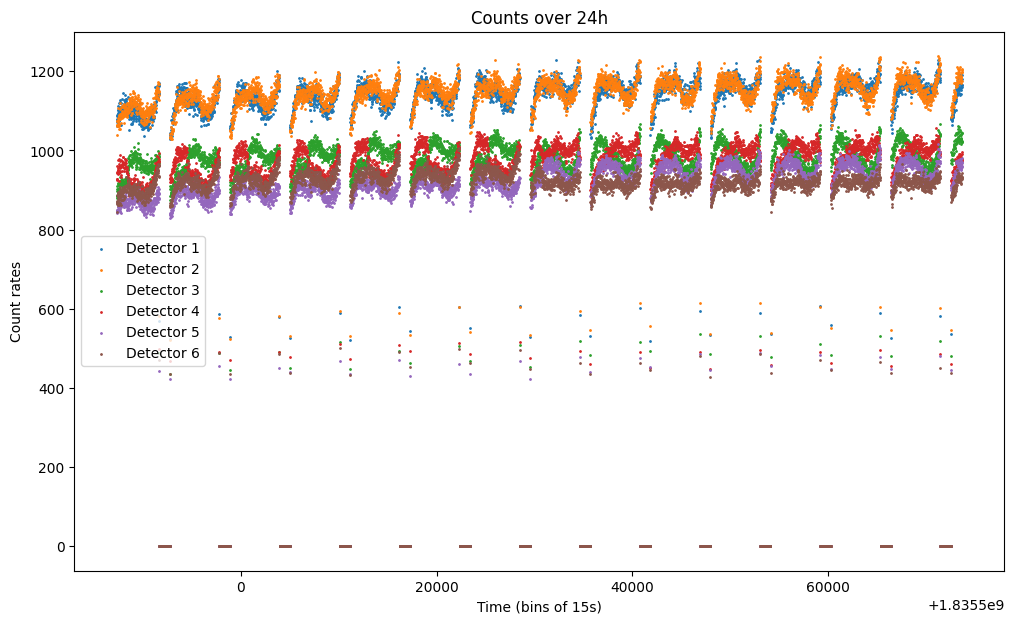

In [21]:
plt.figure(figsize = (12, 7))
for i in range(len(total_rates_15s[0])):
  plt.scatter(x = satellite_data_15s["timestamp"],
              y = satellite_data_15s[f"{target_count_str}{i+1}"],
              s = 1, label = f"Detector {i+1}")
plt.title("Counts over 24h")
plt.xlabel("Time (bins of 15s)")
plt.ylabel("Count rates")
plt.legend()
plt.show()

<a name="countrate_hm"></a>
##### Count rates **heatmap**
Let's visualize from a different *p.o.v.* how count rates vary over time for each detector.

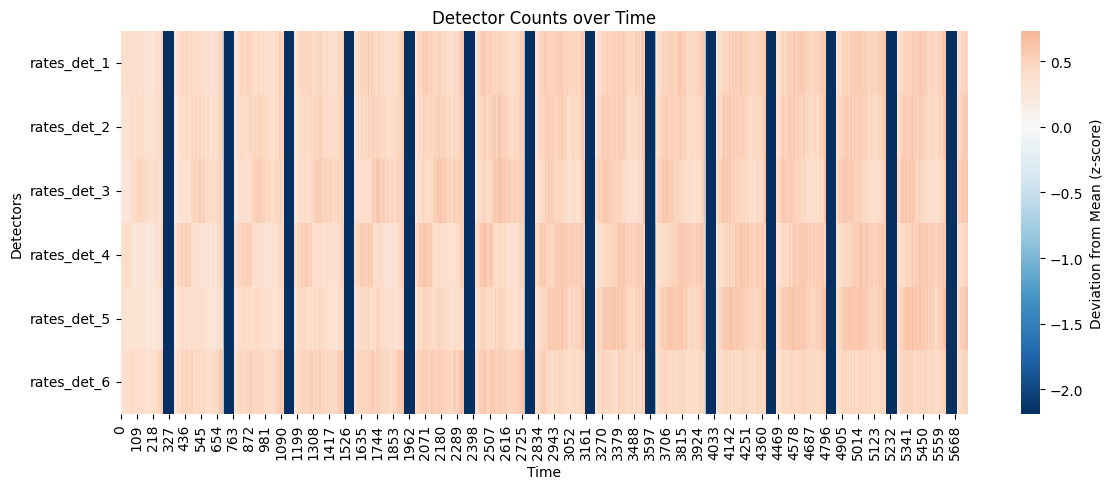

In [22]:
# Select only the detectors' count rate columns
detector_cols = [col for col in satellite_data_15s.columns if f"{target_count_str}" in col]
counts = satellite_data_15s[detector_cols]

# Standardize each detector column: (x - mean) / std
# So values below mean are negative (blue), above mean positive (red)
counts_normalized = (counts - counts.mean()) / counts.std()

# Plot heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(
    counts_normalized.T,  # transpose → detectors on y-axis, time on x-axis
    cmap=sns.color_palette("RdBu_r", as_cmap=True),   # red = above mean, blue = below mean, white = near mean
    center=0,             # zero centered on white
    cbar_kws={'label': 'Deviation from Mean (z-score)'}
)

plt.title("Detector Counts over Time")
plt.xlabel("Time")
plt.ylabel("Detectors")
plt.tight_layout()
plt.show()

> As we can see, the blanks between count rates in the previous plot correspond to values well below the mean, the **zeros**. Here, we can observe that the early values are slightly below the mean, while the subsequent ones are mostly above it.


> Why are the initial count rates lower than average? In the next section, we’ll find out.

<a name="zeropercissue"></a>
##### **Issue**: zero values percentage

> There are many zeros in our count rate columns. This can be also seen in the heatmap above. They are identical across all detectors, which explains some of the observed periodicity.

In [23]:
zero_count_df_15s = (satellite_data_15s[[f"{target_count_str}{i+1}" for i in range(6)]] == 0).sum()
print(f"Percentage of zeros in each column: {zero_count_df_15s.iloc[0] / satellite_data_15s.shape[0]*100:.1f}%")

Percentage of zeros in each column: 17.1%


In [24]:
zero_count_df_50ms = (satellite_data_50ms[[f"{target_count_str}{i+1}" for i in range(6)]] == 0).sum()
print(f"Percentage of zeros in each column: {zero_count_df_50ms.iloc[0] / satellite_data_50ms.shape[0]*100:.1f}%")

Percentage of zeros in each column: 17.3%


In [25]:
zero_count_df_1s = (satellite_data_1s[[f"{target_count_str}{i+1}" for i in range(6)]] == 0).sum()
print(f"Percentage of zeros in each column: {zero_count_df_1s.iloc[0] / satellite_data_1s.shape[0]*100:.1f}%")

Percentage of zeros in each column: 17.3%


> Indeed, they account for approximately **17%** of each series—a non-negligible proportion.

### A series of **clarifications**

#### 1) Stabilization time
We will only consider data from the second half of the day, starting from the **13th hour**. This is because during the first 12 hours the satellite is still activating, and its emission has not yet reached full intensity.

This behavior can also be observed in the previous [plot](#countrate_hm), where the count rates appear to stabilize around the 13th hour.

Finally, we will convert the timestamp column into a DateTime object to better reflect this temporal structure.

In [26]:
# Selecting the second half of the df
def splitting_data(satellite_df, time_res):
  rocking_time_idx = int(len(satellite_df) / 2)
  satellite_data = satellite_df[rocking_time_idx:].copy().reset_index(drop=True)

  # Define desired time res. step
  dt = time_res  # seconds
  n_rows = len(satellite_data)

  # Build new timestamps starting at 13:00:00
  start_time = pd.Timestamp("2025-01-01 13:00:00") # we choose this date
  new_timestamps = start_time + pd.to_timedelta(np.arange(n_rows) * dt, unit="s")

  # Assign back
  satellite_data["timestamp"] = new_timestamps
  return satellite_data, rocking_time_idx

In [27]:
satellite_data_50ms_split, _ = splitting_data(satellite_data_50ms, 0.05)
satellite_data_1s_split, _ = splitting_data(satellite_data_1s, 1)
satellite_data_15s_split, rocking_time_idx = splitting_data(satellite_data_15s, 15)
print(f"Shapes after splitting: {satellite_data_50ms_split.shape}, {satellite_data_1s_split.shape}, {satellite_data_15s_split.shape}")

Shapes after splitting: (864000, 14), (43200, 14), (2880, 14)


In [28]:
display(satellite_data_15s_split.head())

timestamp      x_lat      x_lon      z_lat      z_lon  \
0 2025-01-01 13:00:00  47.799436  27.304168 -42.200564  27.304168   
1 2025-01-01 13:00:15  47.376455  29.632230 -42.623545  29.632230   
2 2025-01-01 13:00:30  46.994069  31.946140 -43.005931  31.946140   
3 2025-01-01 13:00:45  46.652279  34.245897 -43.347721  34.245897   
4 2025-01-01 13:01:00  46.351083  36.531501 -43.648917  36.531501   

   altitude(km)  Earth_lat  Earth_lon  rates_det_1  rates_det_2  rates_det_3  \
0    523.598404  -0.000146  40.102382  1200.600000  1182.733333   993.400000   
1    523.621089  -0.000146  40.981703  1185.133333  1157.866667   975.600000   
2    523.644631  -0.000146  41.861039  1163.733333  1143.333333   982.933333   
3    523.669025  -0.000146  42.740388  1154.400000  1158.066667   961.200000   
4    523.694262  -0.000146  43.619752  1164.933333  1156.466667  1001.400000   

   rates_det_4  rates_det_5  rates_det_6  
0  1008.266667   936.733333   957.600000  
1  1033.266667   930.133333   961.133333  
2  1000.533333   949.533333   955.133333  
3  1010.133333   934.933333   932.533333  
4  1004.533333   909.933333   948.000000

#### 2) Handling zero values

As spotted [before](#zeropercissue), the dataframe is plenty of zeros. But why is that?


<a name="saa"></a>
###### The South Atlantic Anomaly
> "The South Atlantic Anomaly (SAA) is an area where Earth's inner Van Allen radiation belt comes closest to Earth's surface, dipping down to an altitude of 200 kilometres (120 mi). This leads to an increased flux of energetic particles in this region and exposes orbiting satellites (including the ISS) to higher-than-usual levels of ionizing radiation."
>
> — [Wikipedia](https://en.wikipedia.org/wiki/South_Atlantic_Anomaly)

This means that the satellite is **off** while it transits the SAA. Indeed, the satellite gathers zero count rates in those temporal windows.

Because of that, we can safely delete those rows which contain zero values in their count rates columns.

In [29]:
def remove_zeros(satellite_df):
  zeros_mask = (satellite_df[[f"{target_count_str}{i+1}" for i in range(6)]] == 0).any(axis=1)
  satellite_data_nozeros = satellite_df[~zeros_mask].copy()
  print(f"Number of rows deleted: {satellite_df[zeros_mask].shape[0]}")
  return satellite_data_nozeros

In [30]:
satellite_data_50ms_nozeros = remove_zeros(satellite_data_50ms_split)
satellite_data_1s_nozeros = remove_zeros(satellite_data_1s_split)
satellite_data_15s_nozeros = remove_zeros(satellite_data_15s_split)

Number of rows deleted: 148495
Number of rows deleted: 7418
Number of rows deleted: 488


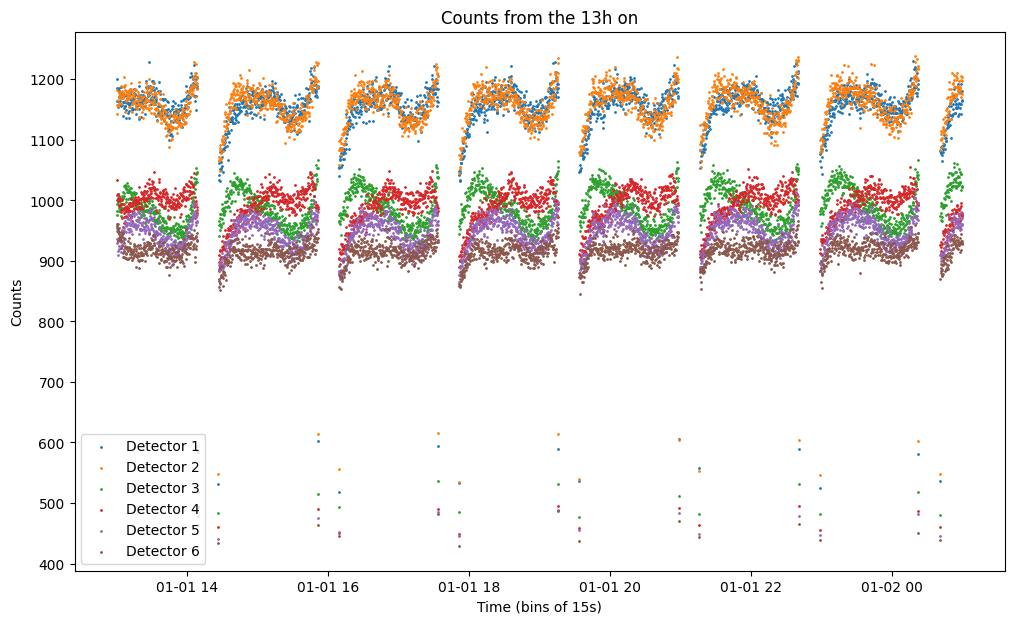

In [31]:
plt.figure(figsize = (12, 7))
for i in range(len(total_rates_15s[1])):
  plt.scatter(x = satellite_data_15s_nozeros["timestamp"],
              y = satellite_data_15s_nozeros[f"{target_count_str}{i+1}"],
              s = 1, label = f"Detector {i+1}")
plt.title("Counts from the 13h on")
plt.xlabel("Time (bins of 15s)")
plt.ylabel("Counts")
plt.legend()
plt.show()

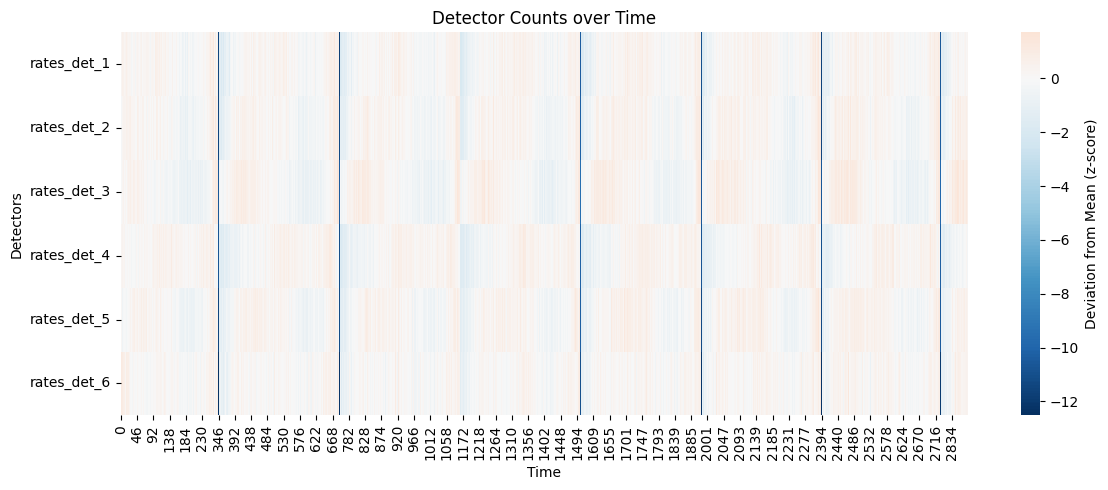

In [32]:
detector_cols = [col for col in satellite_data_15s_nozeros.columns if f"{target_count_str}" in col]
counts = satellite_data_15s_nozeros[detector_cols]

# Standardize each detector column: (x - mean) / std
# So values below mean are negative (blue), above mean positive (red)
counts_normalized = (counts - counts.mean()) / counts.std()

# Plot heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(
    counts_normalized.T,  # transpose → detectors on y-axis, time on x-axis
    cmap=sns.color_palette("RdBu_r", as_cmap=True),   # red = above mean, blue = below mean, white = near mean
    center=0,             # zero centered on white
    cbar_kws={'label': 'Deviation from Mean (z-score)'}
)

plt.title("Detector Counts over Time")
plt.xlabel("Time")
plt.ylabel("Detectors")
plt.tight_layout()
plt.show()

### **Statistical** analysis
A more insightful analysis of our orientation dataframe.

In [33]:
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA
from scipy import stats

Creating a sub-dataframe with only satellite input features:

In [34]:
satellite_data_input = satellite_data_15s_nozeros.copy().drop(columns=["timestamp"] + [f"{target_count_str}{i+1}" for i in range(6)])
display(satellite_data_input.head())

x_lat      x_lon      z_lat      z_lon  altitude(km)  Earth_lat  \
0  47.799436  27.304168 -42.200564  27.304168    523.598404  -0.000146   
1  47.376455  29.632230 -42.623545  29.632230    523.621089  -0.000146   
2  46.994069  31.946140 -43.005931  31.946140    523.644631  -0.000146   
3  46.652279  34.245897 -43.347721  34.245897    523.669025  -0.000146   
4  46.351083  36.531501 -43.648917  36.531501    523.694262  -0.000146   

   Earth_lon  
0  40.102382  
1  40.981703  
2  41.861039  
3  42.740388  
4  43.619752

In [35]:
satellite_data_15s_nozeros.drop(["timestamp"], axis=1).describe()

x_lat        x_lon        z_lat        z_lon  altitude(km)  \
count  2392.000000  2392.000000  2392.000000  2392.000000   2392.000000   
mean     57.401124   104.138229     5.274565   150.944249    527.187677   
std      22.459382    69.183922    39.239296    70.886226      2.413470   
min       5.251886     8.181763   -44.620620     0.637453    523.323631   
25%      49.140200    38.792703   -29.662745    82.167365    524.849799   
50%      59.835151    90.903992    -3.137080   163.722677    527.527643   
75%      74.935771   164.106121    31.513310   202.006230    529.569354   
max      89.995229   237.654764    84.748114   359.870996    530.223516   

         Earth_lat    Earth_lon  rates_det_1  rates_det_2  rates_det_3  \
count  2392.000000  2392.000000  2392.000000  2392.000000  2392.000000   
mean     -0.000162   151.862725  1151.931912  1155.086594   986.200390   
std       0.000094    92.440272    54.032405    53.115816    47.493418   
min      -0.000356     0.003675   517.733333   535.533333   477.000000   
25%      -0.000227    73.266170  1142.466667  1137.600000   964.783333   
50%      -0.000168   148.424706  1159.400000  1162.033333   986.766667   
75%      -0.000098   223.504575  1174.133333  1178.933333  1012.900000   
max       0.000043   359.920292  1229.733333  1238.200000  1067.266667   

       rates_det_4  rates_det_5  rates_det_6  
count  2392.000000  2392.000000  2392.000000  
mean    988.320373   944.329933   913.395875  
std      48.709192    44.064020    38.739435  
min     448.733333   440.866667   428.600000  
25%     977.133333   929.466667   907.466667  
50%     996.733333   949.500000   917.133333  
75%    1010.933333   965.666667   926.133333  
max    1055.866667  1015.600000   967.066667

#### Histograms
To check outliers and data skewness.

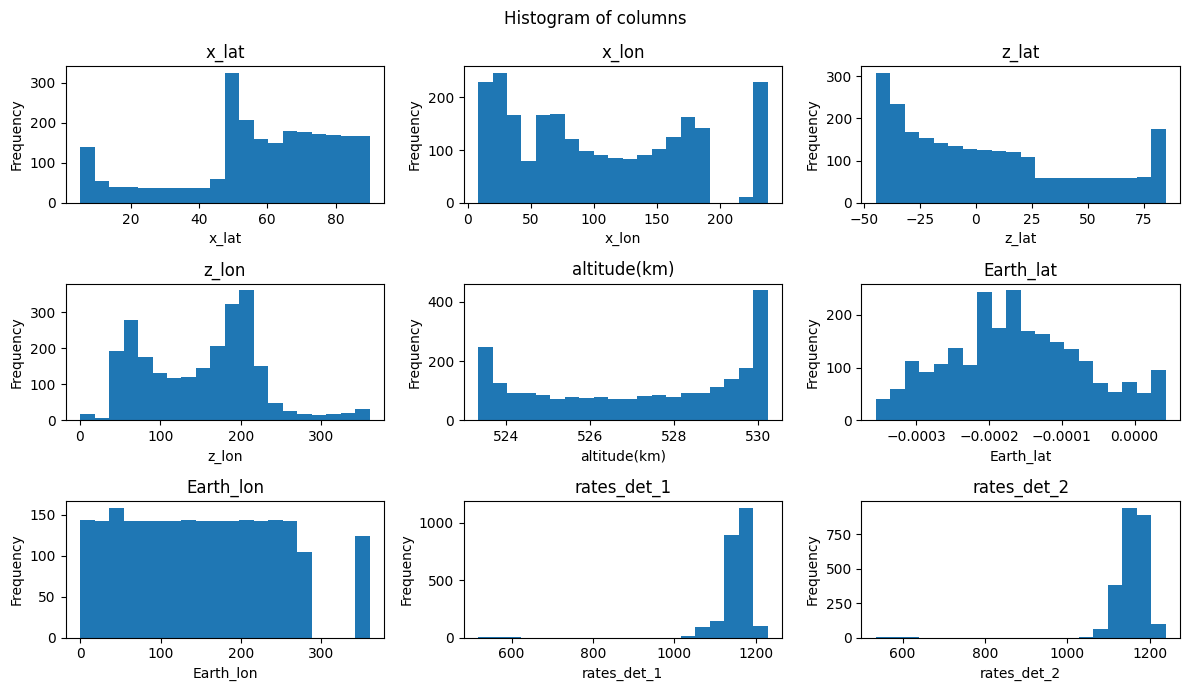

In [36]:
nrows = 3
fig, ax = plt.subplots(nrows=nrows, ncols=nrows, figsize=(12, 7))
fig.suptitle("Histogram of columns")

# Get the list of columns to plot
cols_to_plot = satellite_data_15s_nozeros.columns[1:10]

for i, col in zip(range(len(cols_to_plot)), cols_to_plot):
    ax[i // nrows, i % nrows].hist(satellite_data_15s_nozeros[col], bins=20)
    ax[i // nrows, i % nrows].set_title(col)
    ax[i // nrows, i % nrows].set_xlabel(col)
    ax[i // nrows, i % nrows].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

#### Boxplots
To check outliers, medians, etc.

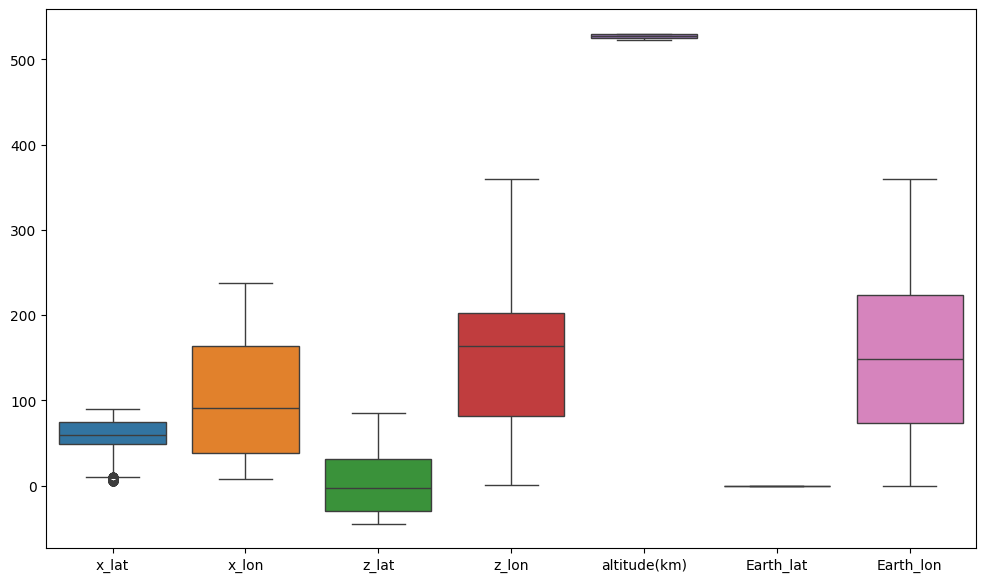

In [37]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=satellite_data_15s_nozeros.iloc[:, :8])
plt.show()

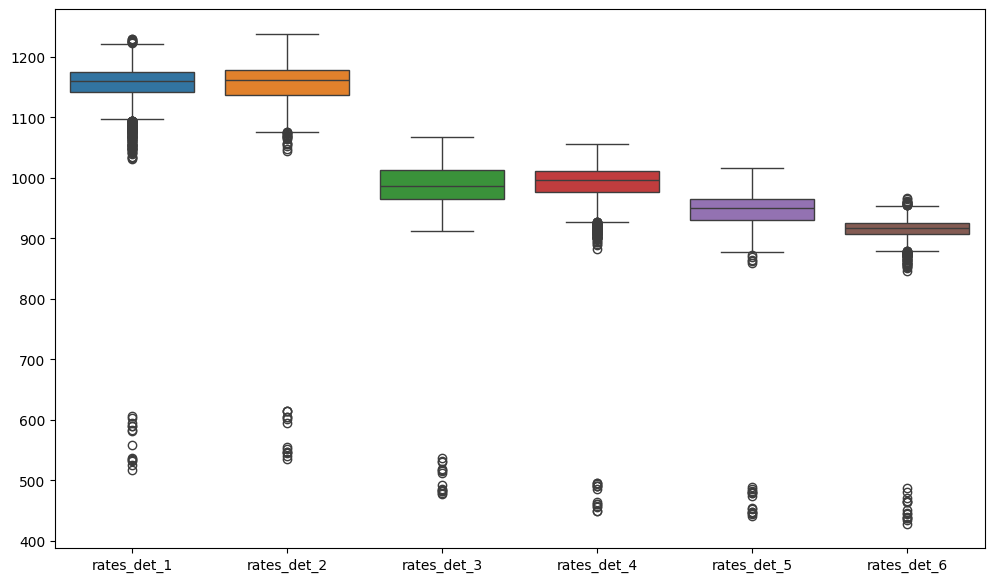

In [38]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=satellite_data_15s_nozeros.iloc[:, 8:])
plt.show()

> We notice a lot of **outliers** for our data! We decide to **remove** them because our aim is to just **fit the background**.
>
> Our data are strongly *left-skewed*.

##### Removing outliers
We will try to use a Interquartile Range (or **IQR**) method, because our data are skewed (there is a long tail on the left).

In [39]:
threshold_dict = {"15s": 0.4,
                  "1s" : 0.2,
                  "50ms": 0.8}

satellite_nozeros_dict = {
    "15s": satellite_data_15s_nozeros,
    "1s": satellite_data_1s_nozeros,
    "50ms": satellite_data_50ms_nozeros
}

In [40]:
def remove_outliers_IQR(satellite_df):
  num_cols = satellite_df.select_dtypes(include=np.number).columns
  Q1 = satellite_df[num_cols].quantile(0.25)
  Q3 = satellite_df[num_cols].quantile(0.75)
  IQR = Q3 - Q1

  lower = Q1 - 1.5 * IQR
  upper = Q3 + 1.5 * IQR

  mask = (satellite_df[num_cols] >= lower) & (satellite_df[num_cols] <= upper)
  mask_all = mask.all(axis=1)

  satellite_data_filtered = satellite_df[mask_all]
  print(f"Number of rows deleted: {satellite_df.shape[0] - satellite_data_filtered.shape[0]}")
  return satellite_data_filtered

def remove_outliers_MAD(df_name, df_dict, threshold_dict):
    df = df_dict[df_name]
    threshold = threshold_dict[df_name]

    cols = df.iloc[:, 8:].columns
    med = df[cols].median()
    rel_dev = np.abs(df[cols] - med) / med
    mask = (rel_dev <= threshold).all(axis=1)
    return df[mask].copy()

def remove_outliers_quantiles(df):
  num_cols = df.select_dtypes(include=np.number).columns
  lower = df[num_cols].quantile(0.004)
  upper = df[num_cols].quantile(0.999)
  mask = ((df[num_cols] >= lower) & (df[num_cols] <= upper)).all(axis=1)
  df_filtered = df[mask]
  return df_filtered

In [41]:
# IQR filtering — removing all above and below 1.5 * IQR
print("IQR — 15s, 1s, 50ms")
satellite_data_15s_filter_IQR = remove_outliers_IQR(satellite_data_15s_nozeros)
satellite_data_1s_filter_IQR = remove_outliers_IQR(satellite_data_1s_nozeros)
satellite_data_50ms_filter_IQR = remove_outliers_IQR(satellite_data_50ms_nozeros)

# MAD filtering — removing based on median
satellite_data_15s_filter_MAD = remove_outliers_MAD("15s", satellite_nozeros_dict, threshold_dict)
satellite_data_1s_filter_MAD = remove_outliers_MAD("1s", satellite_nozeros_dict, threshold_dict)
satellite_data_50ms_filter_MAD = remove_outliers_MAD("50ms", satellite_nozeros_dict, threshold_dict)
print(f"\nMAD — 15s, 1s, 50ms\nNumber of rows deleted: {satellite_data_15s_nozeros.shape[0] - satellite_data_15s_filter_MAD.shape[0]}")
print(f"Number of rows deleted: {satellite_data_1s_nozeros.shape[0] - satellite_data_1s_filter_MAD.shape[0]}")
print(f"Number of rows deleted: {satellite_data_50ms_nozeros.shape[0] - satellite_data_50ms_filter_MAD.shape[0]}")

# Q tail filtering — removing the 0.5% of the distribution at its tails
satellite_data_15s_filter_q = remove_outliers_quantiles(satellite_data_15s_nozeros)
satellite_data_1s_filter_q = remove_outliers_quantiles(satellite_data_1s_nozeros)
satellite_data_50ms_filter_q = remove_outliers_quantiles(satellite_data_50ms_nozeros)
print(f"\nQ — 15s, 1s, 50ms\nNumber of rows deleted: {satellite_data_15s_nozeros.shape[0] - satellite_data_15s_filter_q.shape[0]}")
print(f"Number of rows deleted: {satellite_data_1s_nozeros.shape[0] - satellite_data_1s_filter_q.shape[0]}")
print(f"Number of rows deleted: {satellite_data_50ms_nozeros.shape[0] - satellite_data_50ms_filter_q.shape[0]}")

IQR — 15s, 1s, 50ms
Number of rows deleted: 321
Number of rows deleted: 3513
Number of rows deleted: 76930

MAD — 15s, 1s, 50ms
Number of rows deleted: 14
Number of rows deleted: 26
Number of rows deleted: 1810

Q — 15s, 1s, 50ms
Number of rows deleted: 111
Number of rows deleted: 1977
Number of rows deleted: 40281


In [42]:
# Update the original dataframes with the modified ones
satellite_data_dict["15s"] = satellite_data_15s_filter_q
satellite_data_dict["1s"] = satellite_data_1s_filter_q
satellite_data_dict["50ms"] = satellite_data_50ms_filter_q

In [43]:
# Compare mean differences between original and filtered datasets
def comparing_means(df_dict_original, df_dict_filtered):
    for df_name in df_dict_original.keys():
        df_original = df_dict_original[df_name]
        df_filtered = df_dict_filtered[df_name]
        rates = df_original.columns[8:]  # detector columns

        pct_diffs = []  # store % difference per detector

        for det_r in rates:
            mean_orig = df_original[det_r].mean()
            mean_filt = df_filtered[det_r].mean()
            diff_pct = (mean_filt - mean_orig) / mean_orig * 100
            pct_diffs.append(diff_pct)

        avg_diff = np.mean(pct_diffs)
        print(f"Avg mean across detectors ({df_name}): {avg_diff:.3f}%")

# Run comparation
comparing_means(
    df_dict_original=satellite_nozeros_dict,
    df_dict_filtered=satellite_data_dict
)


Avg mean across detectors (15s): 0.270%
Avg mean across detectors (1s): 0.111%
Avg mean across detectors (50ms): 0.290%


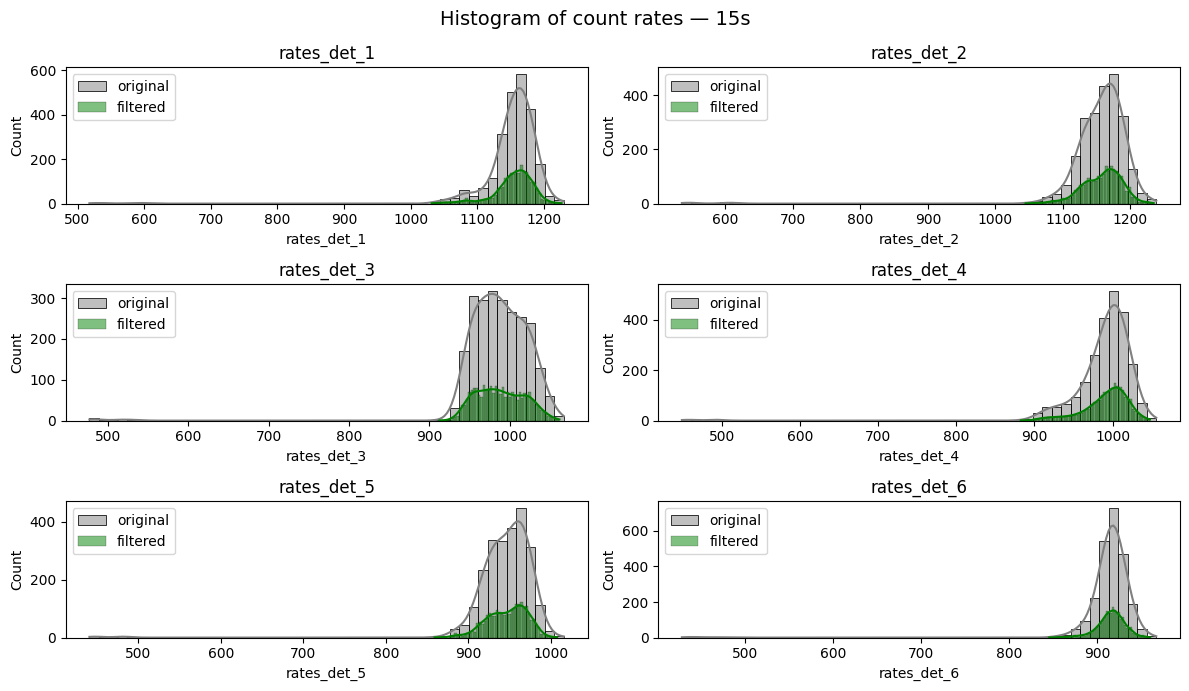

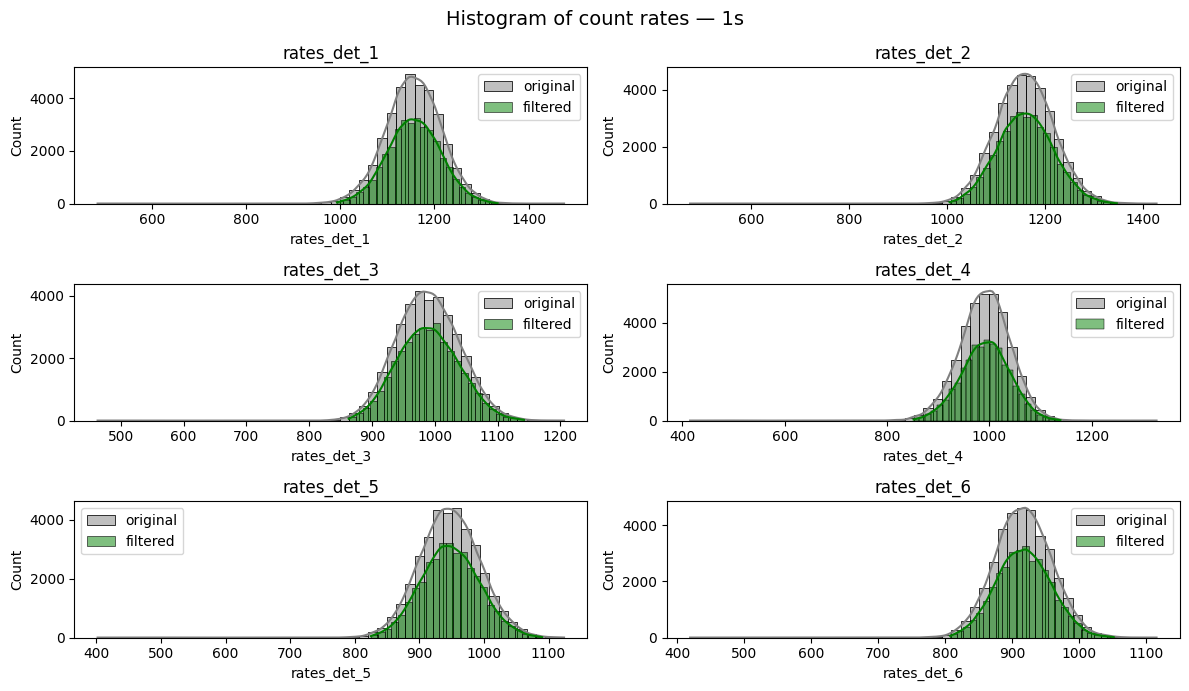

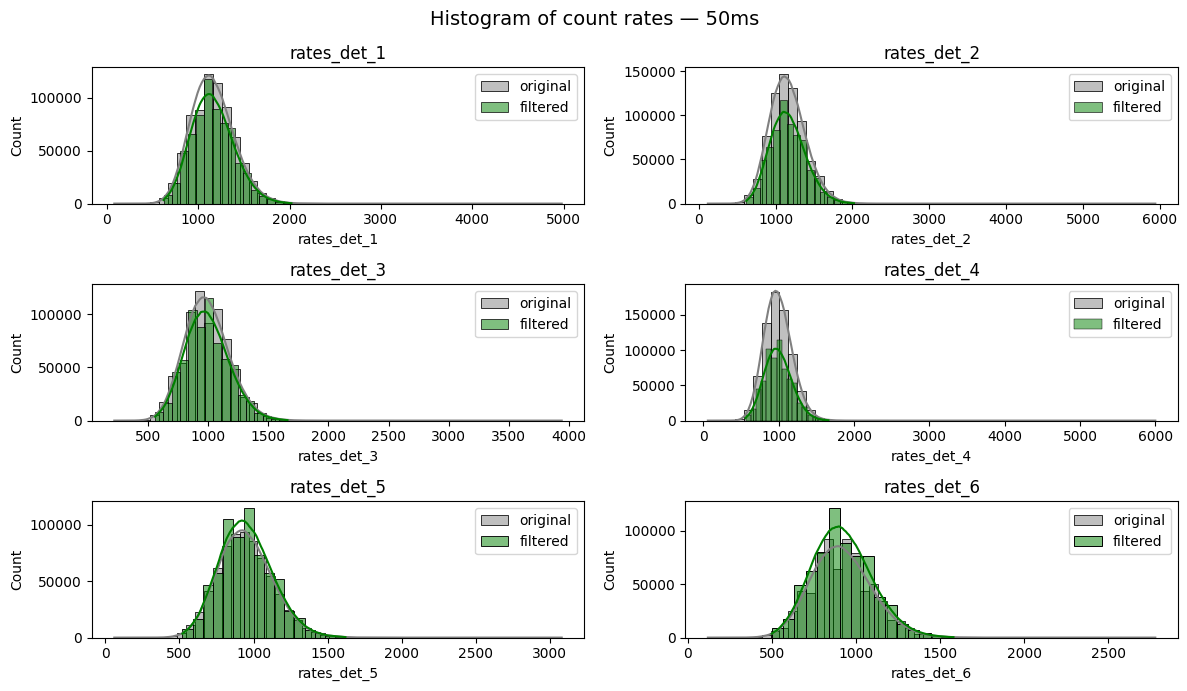

In [44]:
# Plot histograms
nrows = 3
ncols = 2
j = 0

for key in satellite_nozeros_dict.keys():
    df_nozeros = satellite_nozeros_dict[key]
    df_filtered = satellite_data_dict[key]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 7))
    fig.suptitle(f"Histogram of count rates — {key}", fontsize=14)

    # Columns to plot (same for all resolutions)
    cols_to_plot = df_nozeros.columns[8:]
    j += 1

    for i, col in enumerate(cols_to_plot):
        row, c = divmod(i, ncols)
        sns.histplot(df_nozeros[col], bins=50, kde=True, label='original', color='gray', ax=ax[row, c])
        sns.histplot(df_filtered[col], bins=50//j, kde=True, label='filtered', color='green', ax=ax[row, c])
        ax[row, c].set_title(col)
        ax[row, c].legend()

    plt.tight_layout()
    plt.show()


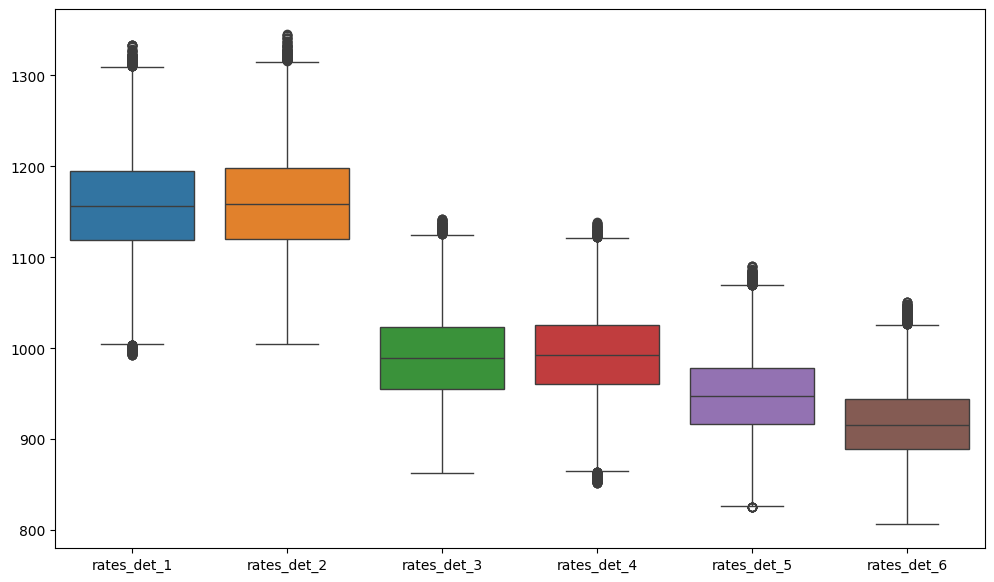

In [45]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=satellite_data_dict["1s"].iloc[:, 8:])
plt.show()

#### KDE plots
To see the shape of the underlying distributions. We will first inspect the ones of the satellite features, for each time-resolution dataframe.

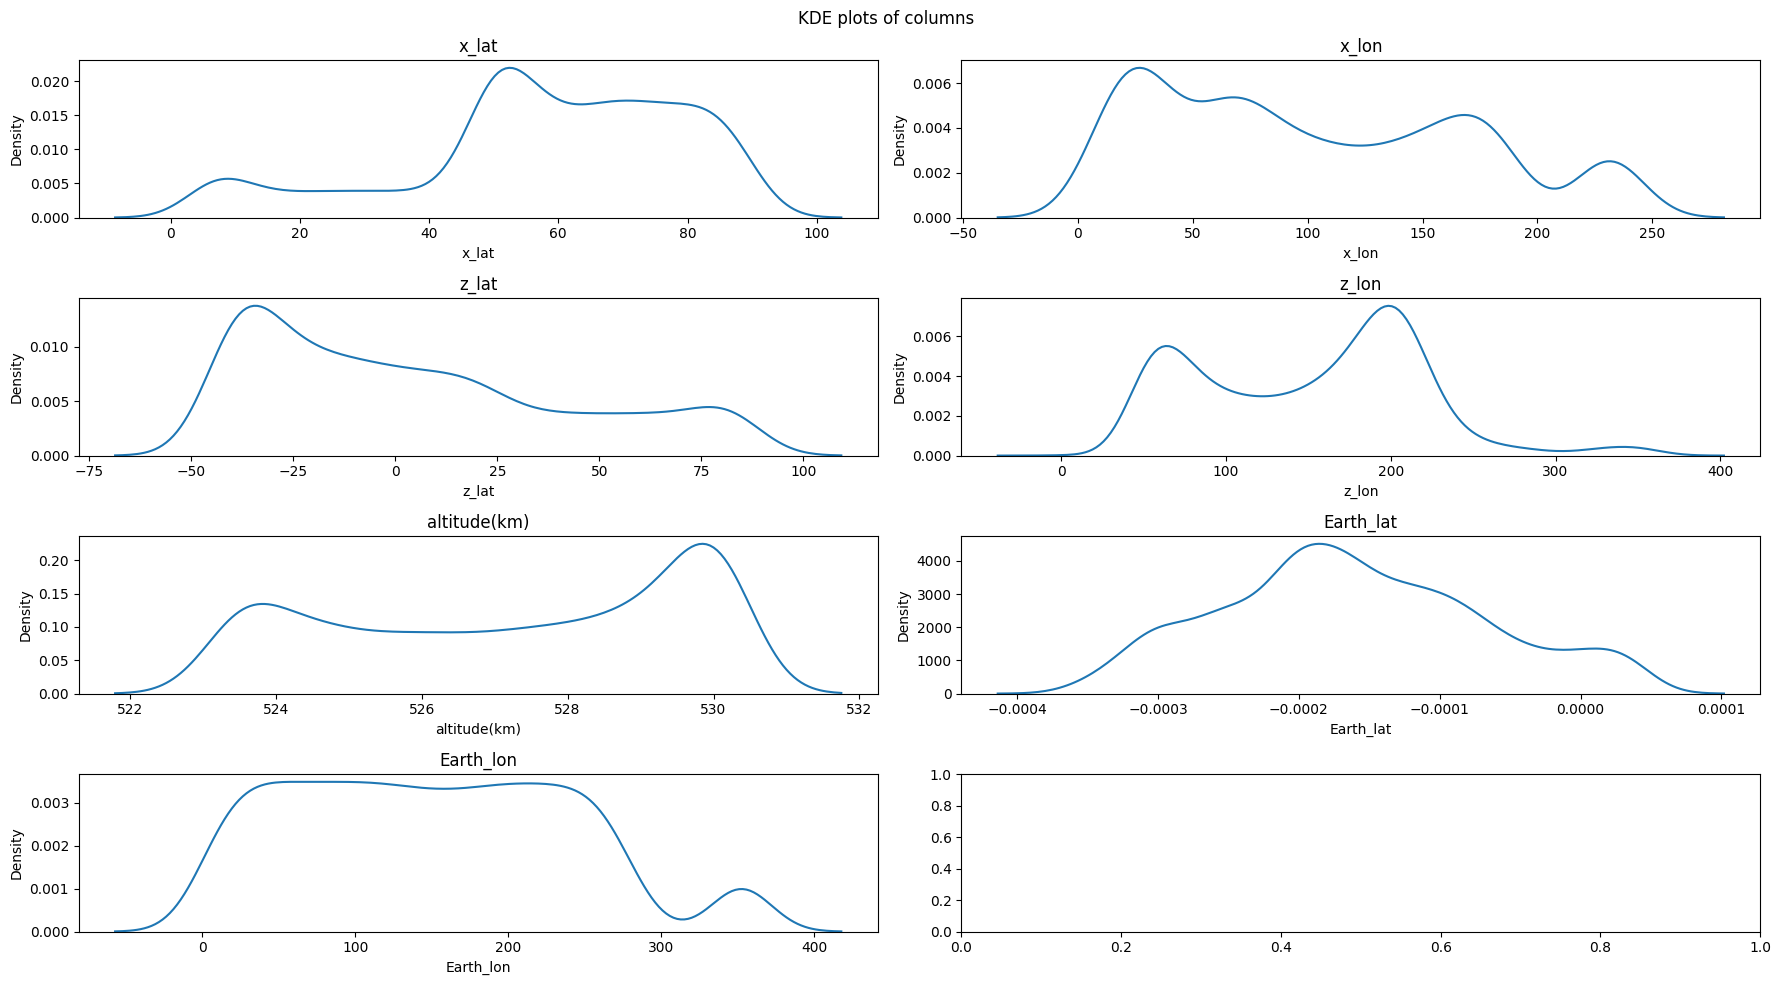

In [46]:
nrows = 4
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10))
fig.suptitle("KDE plots of columns")

# Get the list of columns to plot (first 8 columns from index 1)
cols_to_plot = satellite_data_dict["15s"].columns[1:8]

for i, feature in enumerate(cols_to_plot):
    row, col = divmod(i, ncols)
    sns.kdeplot(data=satellite_data_dict["15s"][feature], ax=ax[row, col])
    ax[row, col].set_title(feature)

plt.tight_layout()
plt.show()

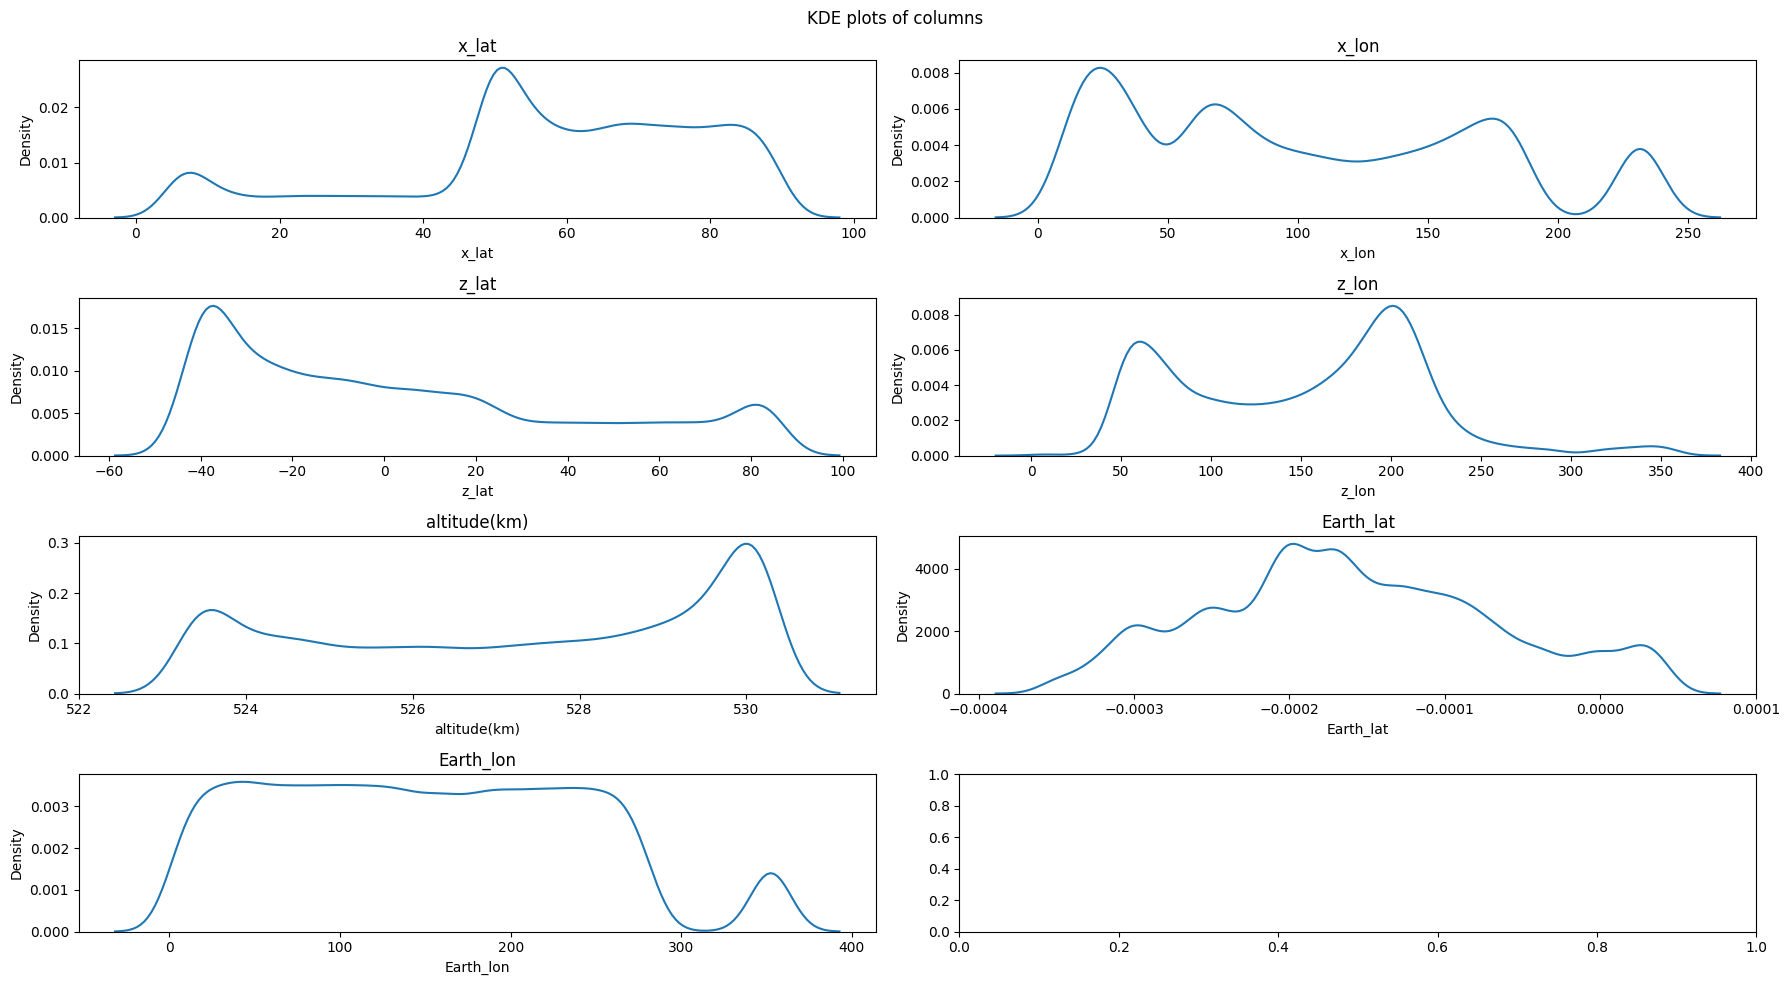

In [47]:
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10))
fig.suptitle("KDE plots of columns")

for i, feature in enumerate(cols_to_plot):
    row, col = divmod(i, ncols)
    sns.kdeplot(data=satellite_data_dict["1s"][feature], ax=ax[row, col])
    ax[row, col].set_title(feature)

plt.tight_layout()
plt.show()

<a name="countrate_distrib"></a>
#### Count rate **distribution**

Which is the probability distribution of our count rates?

> **Note**: we are referring to the ***per-bin*** distribution, not to the one for a time series!
>> This is because our ultimate [goal](#intro) is to predict the per-bin distribution of count rates and to check whether it matches with the true count rate dsitribution.

Theoretically, the underlying process of a counting experiment is a **Poisson**, because we count independent events over a fixed time interval.
Indeed, my physical model is:

$$C_t \sim P(\lambda_t)$$

where:

*   $C_t$ is the observed count in the 15s bin at time $t$
*   $\lambda_t$ is the expected number of photons in that bin
*   $\lambda_t$ depends on the inpute features (orbit, position, etc)

But, how can we infer the mean of a Poisson from only one draw? We cannot, and in reality, we are actually  predicting λ as a deterministic function of the system state. Namely, we just want to earn a mapping from features to expected counts. We predict the parameter (λ) that defines what the Poisson distribution would be if we were to sample from it.
$$P(C_t∣x_t​)=Poisson(f_θ​(x_t​))$$

For exploratory purposes, we will also inspect the count rates timeseries probability distribution twice:

1.   First, we will analyze them choosing a representative window that is the closest to the orbital mean count;

2.   Second, we will split our timeseries into ***windows*** of **500** **seconds**, in order to **avoid** the aforementioned **orbital trends**. This would be our distribution under interest because we want a **stationary** count rate that doesn't fluctuates due to factors like radiation belts (like [SAA](#saa)), Earth occultation, etc.

##### 1) Best window

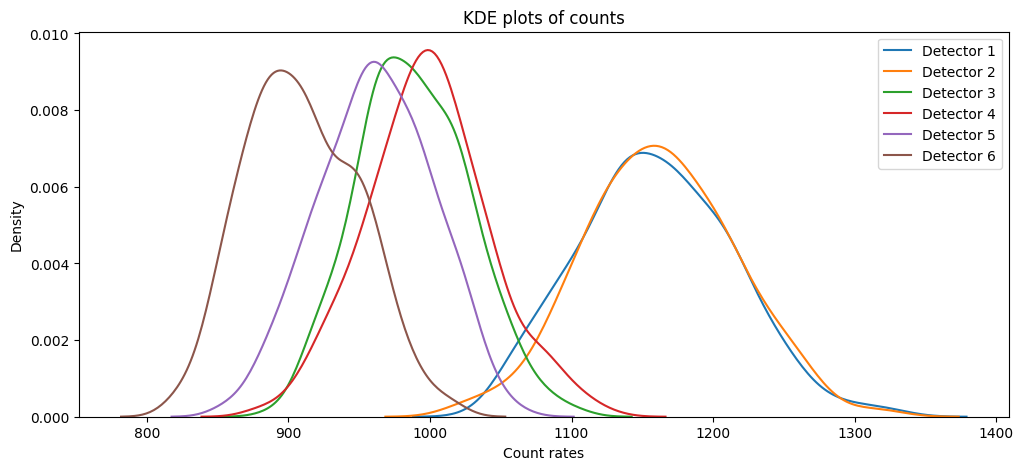

In [48]:
def choose_best_window(window_bins, satellite_data, det_prefix=target_count_str, n_dets=n_detectors):
  # Stack all detectors in a 2D array [time, det]
  counts = np.stack([
      satellite_data[f"{target_count_str}{i+1}"].values
      for i in range(n_dets)
  ], axis=1)  # shape (T, 6)

  start_orbit = 0
  stop_orbit = len(counts)
  det_means = counts.mean(axis=0)  # per-detector global means

  best_start = 0
  min_score = np.inf

  for i in range(stop_orbit - window_bins + 1):
      window = counts[i:i+window_bins, :]  # shape (window_bins, 6)
      mean_window = window.mean(axis=0)    # mean per detector in this window

      # average absolute deviation across detectors
      score = np.mean(np.abs(mean_window - det_means))

      if score < min_score:
          min_score = score
          best_start = i

  best_window = counts[best_start:best_start+window_bins, :]
  return best_start, best_window

# usage
bin_sec = 1
window_bins = int(300 / bin_sec)  # 33 bins
best_start, best_window = choose_best_window(window_bins, satellite_data_dict["1s"])

# plotting
plt.figure(figsize = (12, 5))
for i in range(n_detectors):
  sns.kdeplot(best_window[:, i], label=f'Detector {i+1}')
plt.legend()
plt.xlabel("Count rates")
plt.title("KDE plots of counts")
plt.show()

##### 2) Consecutive windows
We will consider just one window per-detector, that will correspond to the same time range. The starting indices would be non-overlapping.

In [49]:
def windowing_data(time_series, window_size):
    windows = []
    start = 0
    while start < len(time_series):
      windows.append(time_series[start:start+window_size])
      start += window_size
    return windows

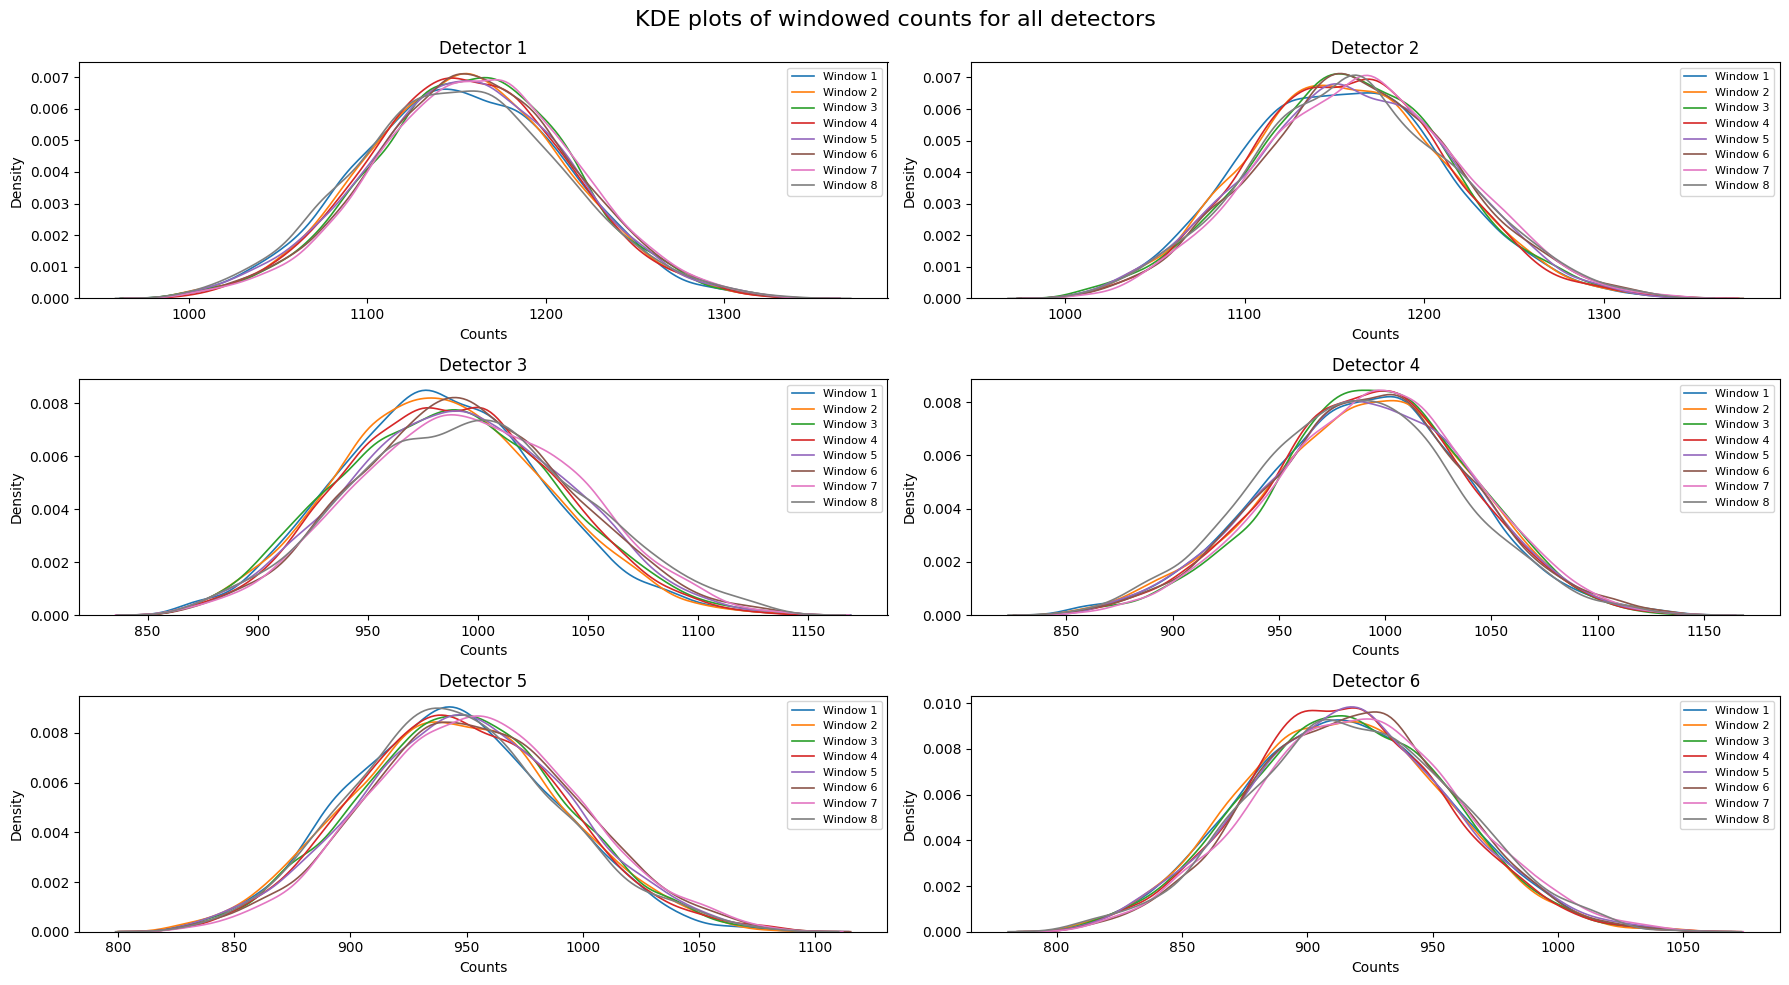

In [50]:
window_size = 300*15
nrows, ncols = 3, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10))
fig.suptitle("KDE plots of windowed counts for all detectors", fontsize=16)

for i in range(n_detectors):
    # Select counts for detector i
    data = satellite_data_dict["1s"][f"{target_count_str}{i+1}"]

    # Get list of windows (e.g. from your custom function)
    windows = windowing_data(data, window_size)

    # Compute subplot coordinates
    row, col = divmod(i, ncols)

    # Plot KDEs for each window on this detector’s subplot
    for j, window in enumerate(windows):
        sns.kdeplot(window, label=f"Window {j+1}", ax=ax[row, col], lw=1.2)

    ax[row, col].set_title(f"Detector {i+1}")
    ax[row, col].set_xlabel("Counts")
    ax[row, col].set_ylabel("Density")
    ax[row, col].legend(fontsize=8)
plt.tight_layout()
plt.show()

> As expected, all the detectors share a **similar** distribution. We can find similarities comparing the above distributions with the "naive" count rates shown [here](#countrates).

> Which kind of distribution is this? Which one best fits our data? Let's find out in the following [section](#fit_distrib).

#### Correlation matrices

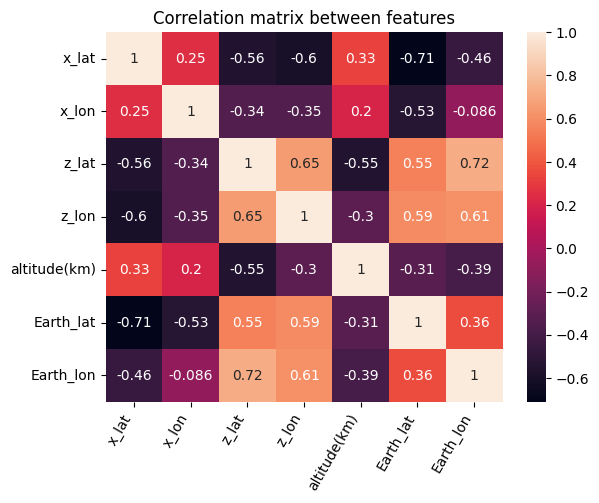

In [51]:
satellite_data_input = satellite_data_dict["15s"].copy().drop(columns=["timestamp"] + [f"{target_count_str}{i+1}" for i in range(6)])
sns.heatmap(satellite_data_input.corr(), annot=True)
plt.xticks(rotation=60, ha='right') # Rotate x-ticks by 45 degrees and align to the right
plt.title("Correlation matrix between features")
plt.show()

Let's plot cross-correlation between detectors' count rates:

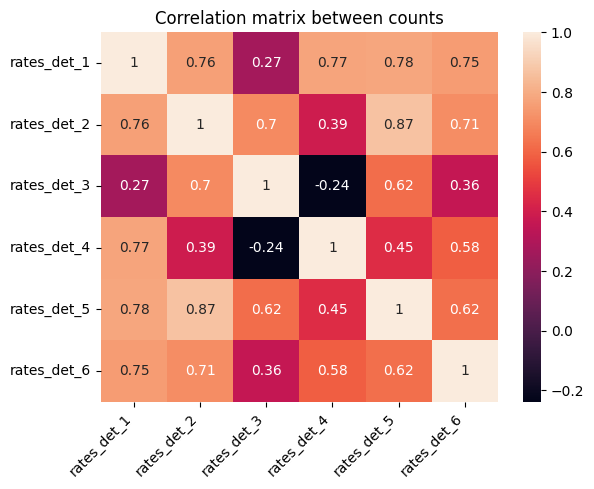

In [52]:
corr_matrix = satellite_data_dict["15s"][[f"{target_count_str}{i+1}" for i in range(6)]].corr()
sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=45, ha='right') # Rotate x-ticks by 45 degrees and align to the right
plt.title("Correlation matrix between counts")
plt.show()

> All detectors are responding almost identically over time. This means that all shows nearly identical temporal patterns. This reflects the identical periodicity showned before.

<a name="corr"></a>
##### Correlation matrix between input features and target features

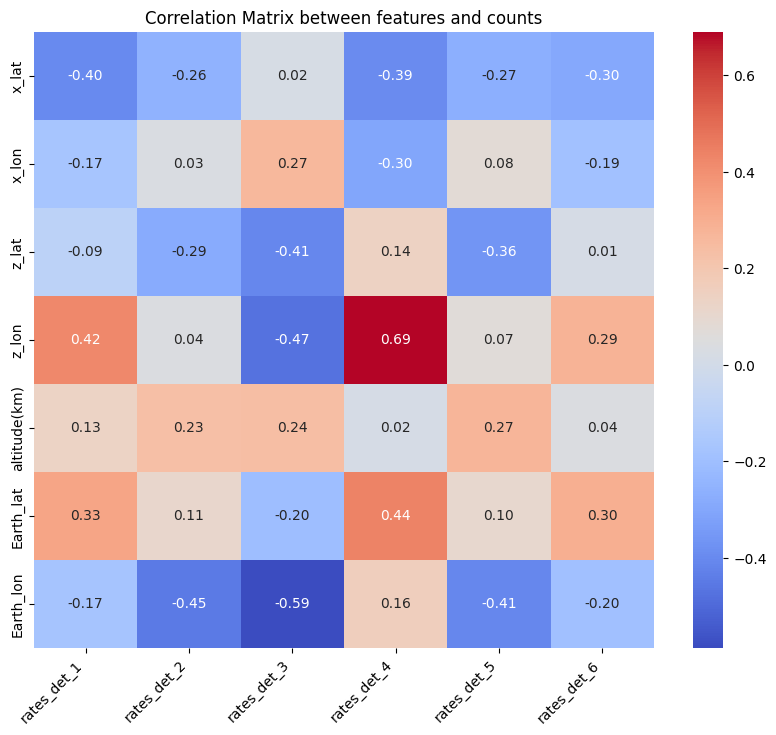

In [53]:
# Concatenate the scaled input features and the count rates
satellite_data_input = satellite_data_dict["15s"].copy().drop(columns=["timestamp"] + [f"{target_count_str}{i+1}" for i in range(6)])
combined_data = pd.concat([satellite_data_input, satellite_data_dict["15s"][[f"{target_count_str}{i+1}" for i in range(6)]]], axis=1)

# Calculate the correlation matrix of the combined data
correlation_matrix_combined = combined_data.corr()

# Select the correlations between the scaled input features and the count rates
correlation_subset = correlation_matrix_combined.loc[satellite_data_input.columns, [f"{target_count_str}{i+1}" for i in range(6)]]

# Plot the heatmap of the correlation subset
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_subset, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix between features and counts")
plt.xticks(rotation=45, ha='right') # Rotate x-ticks by 45 degrees and align to the right
plt.show()

#### Autocorrelation plots
Autocorrelation measures how similar a time series is to a lagged version of itself, that is comparing the current data to previous ones, in the past, at different time steps (lags).

In [54]:
def plot_autocorrelation(data, value, ax, max_lag=3000):
    # Autocorrelation plot on the given axes
    pd.plotting.autocorrelation_plot(data[value], ax=ax)
    # Customized x limits
    ax.set_xlim(0, max_lag)
    # Rotate x ticks using tick_params
    ax.tick_params(axis='x', rotation=45)
    ax.grid(':')
    ax.set_title(value)


def plot_multi_autocorrelation(data, value_prefix=target_count_str, tick_positions=[10], max_lag=100, figsize=(12, 7)):
    plt.figure(figsize=figsize)
    colors = ["red", "yellow", "green", "orange", "purple", "blue"]
    for i in range(6):
        col = f"{value_prefix}{i+1}"
        if col not in data.columns:
            print(f"⚠️ Column {col} not found, skipping.")
            continue
        pd.plotting.autocorrelation_plot(
            data[col],
            label=f"Detector {i}",
            color=colors[i % len(colors)]
        )
    plt.xlim(0, max_lag)
    plt.xticks(tick_positions, rotation=45)
    plt.title("Autocorrelation of Detector Counts")
    plt.grid(':')
    plt.legend()
    plt.tight_layout()
    plt.show()

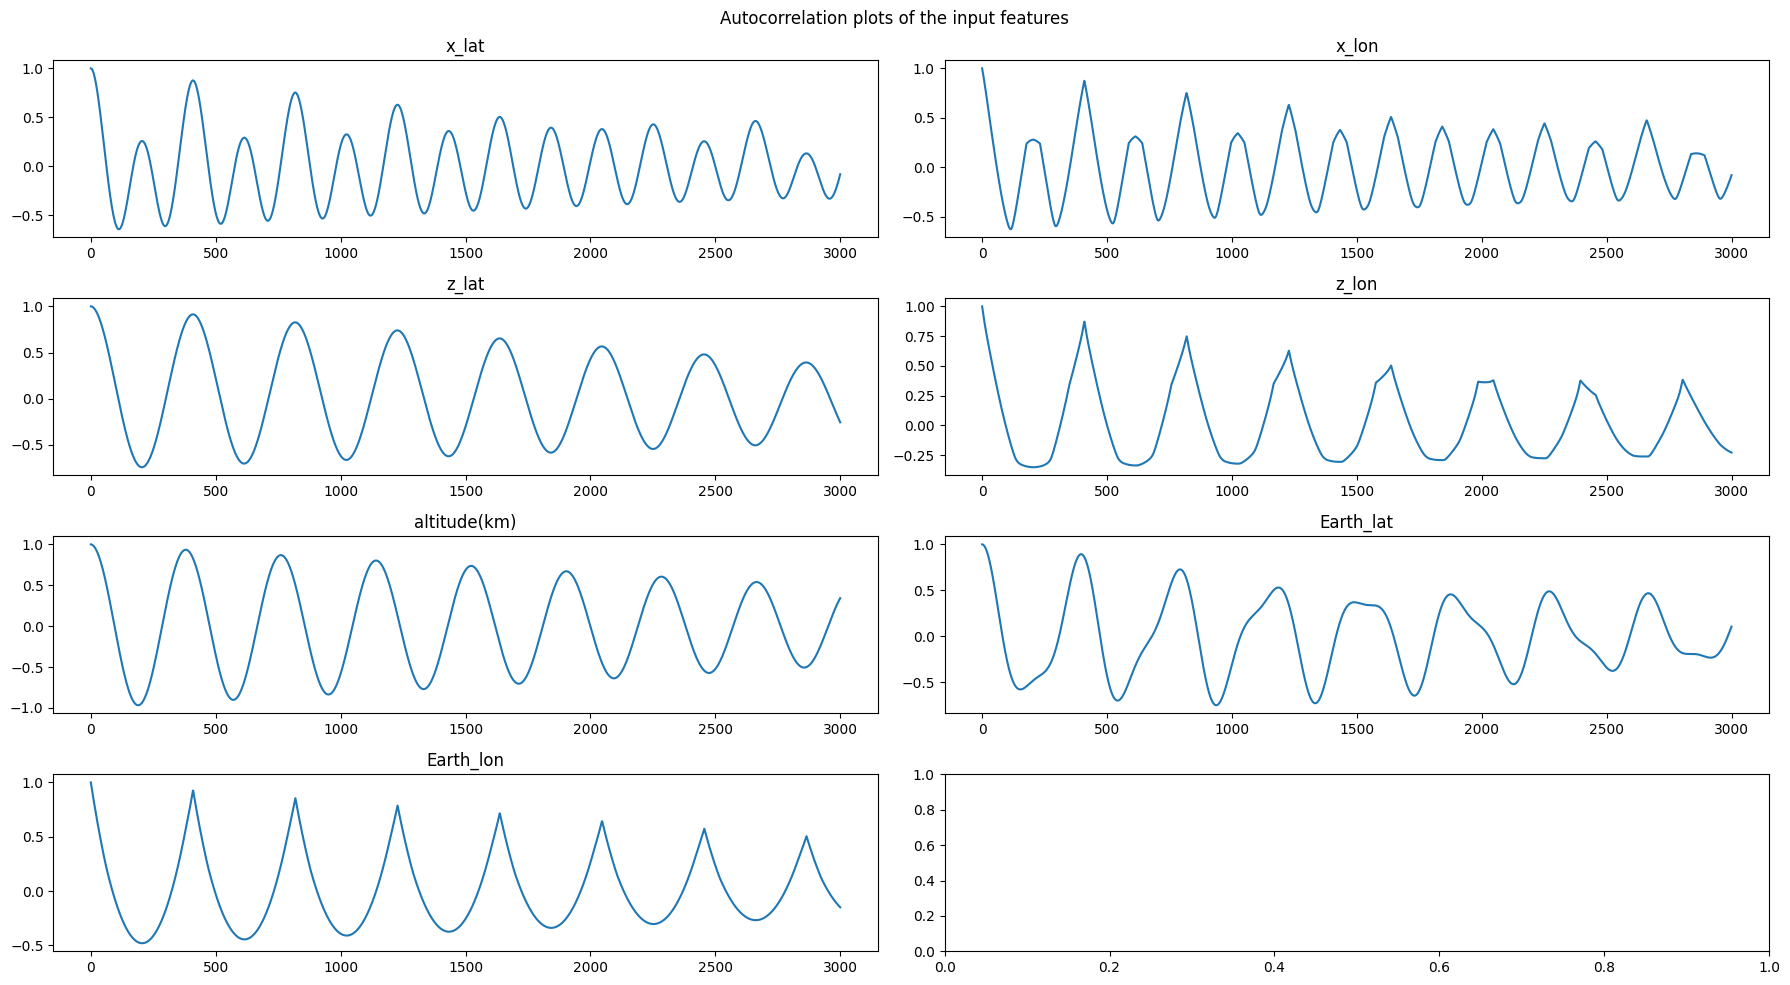

In [55]:
# AC plot for input features
nrows = 4
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10))
fig.suptitle("Autocorrelation plots of the input features")

# Get the list of columns to plot (first 8 columns from index 1)
cols_to_plot = satellite_data_dict["15s"].columns[1:8]

for i, feature in enumerate(cols_to_plot):
    row, col = divmod(i, ncols)
    acf_values = acf(satellite_data_original[feature], nlags=3000)
    ax[row, col].plot(acf_values)
    ax[row, col].set_title(feature)

plt.tight_layout()
plt.show()

In [56]:
# We will take det1 as reference detector, but all detectors share the same peaks
n_det = 1
satellite_data = satellite_data_dict["15s"]

acf_values = acf(satellite_data[f"{target_count_str}{n_det}"], nlags=50000)
peaks, _ = find_peaks(acf_values, prominence=0.04)  # tune prominence to pick main peaks
lag_peaks = peaks
sample_dt = 15  # seconds per sample

periods_sec = np.diff(lag_peaks) * sample_dt
print("lag peaks:", lag_peaks)
print("periods (s):", periods_sec)
print("mean period (s):", periods_sec.mean())
print("mean period (min):", periods_sec.mean()/60.)
print("mean period (hours):", periods_sec.mean()/60/60.)

lag peaks: [ 113  207  326  447  534  655  768  886  984 1096 1199 1311 1424 1522
 1635 1743 1959]
periods (s): [1410 1785 1815 1305 1815 1695 1770 1470 1680 1545 1680 1695 1470 1695
 1620 3240]
mean period (s): 1730.625
mean period (min): 28.84375
mean period (hours): 0.48072916666666665


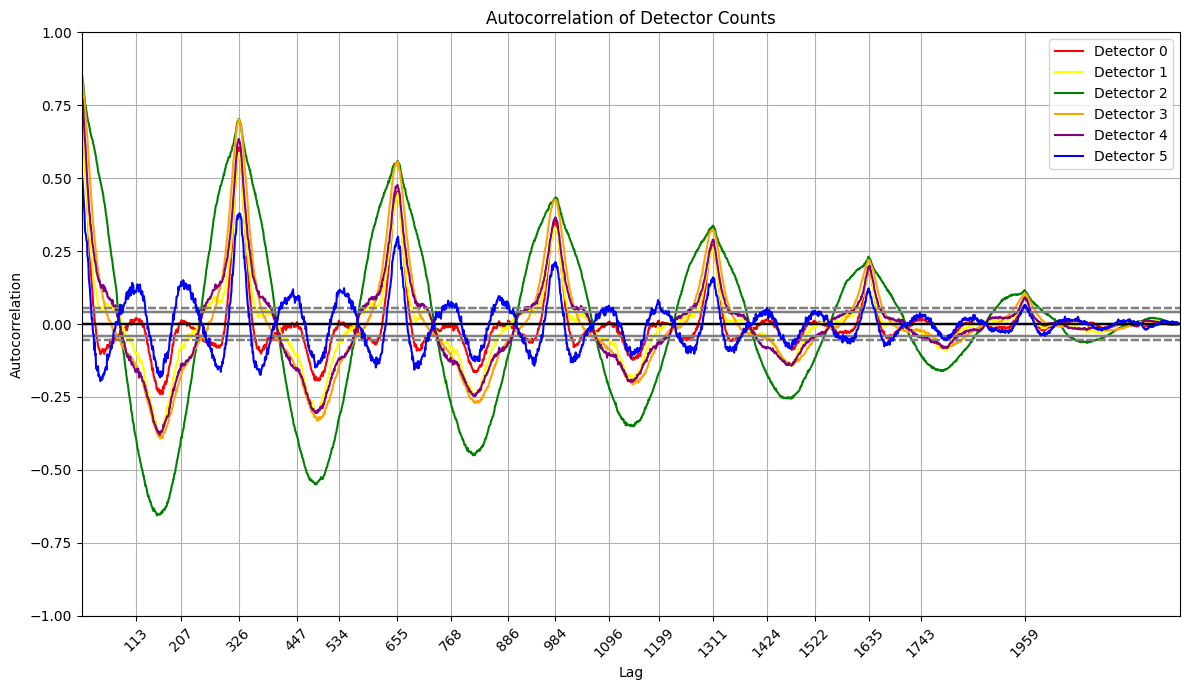

In [57]:
plot_multi_autocorrelation(satellite_data, value_prefix=target_count_str, tick_positions=lag_peaks, max_lag=len(satellite_data), figsize=(12, 7))

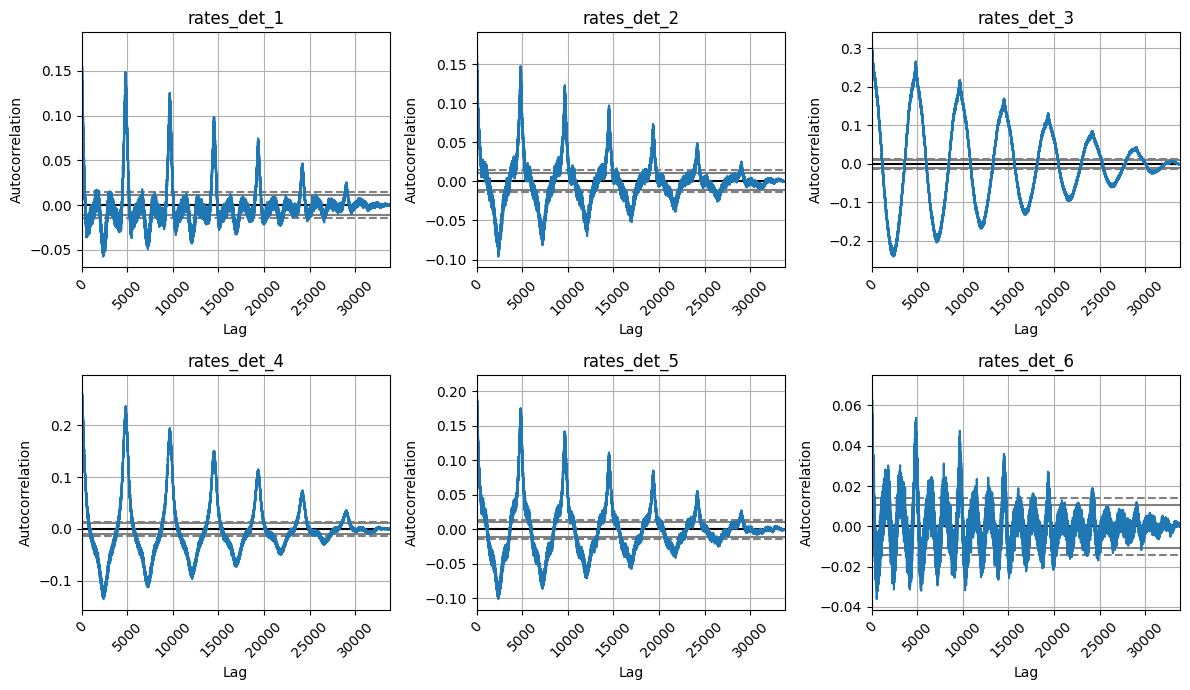

In [58]:
nrows = 2
ncols = 3
satellite_data = satellite_data_dict["1s"]

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 7))
for i in range(6):
  row, col = divmod(i, ncols)
  plot_autocorrelation(satellite_data, value=f"{target_count_str}{i+1}", ax=ax[row, col], max_lag=len(satellite_data))
plt.tight_layout()
plt.show()

> All the detectors share the same correlation pattern. Indeed, there are peaks that are repeating at regular intervals, which suggest **periodicity**. We can also spot a temporal **decay**: the time series is still repeating, but each repetition is a little less similar to the original one.
>> Each peak happens every *296* lags, **~1.23** hours; negative peaks indicate an inverse relationship
>>> The decaying correlation, both positive and negative, means that the pattern decreases over time. This is due to damping or the fact that noise accumulates over time.

#### PCA analysis
We want to visualize the proportion of variance in the original data that is explained by each principal component. The values are ordered from the first principal component to the last.

In [59]:
X = satellite_data_dict["15s"][[f"{target_count_str}{i+1}" for i in range(6)]]
pca = PCA()
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.63884631 0.28315629 0.02822512 0.01898559 0.01731484 0.01347186]


> The output indicates that the first principal component explains almost 60%

#### Overdispersion

Detector 1: mean=1156.56, var/mean=2.712
Detector 2: mean=1159.57, var/mean=2.722
Detector 3: mean=989.57, var/mean=2.368
Detector 4: mean=992.39, var/mean=2.256
Detector 5: mean=948.09, var/mean=2.100
Detector 6: mean=916.75, var/mean=1.794



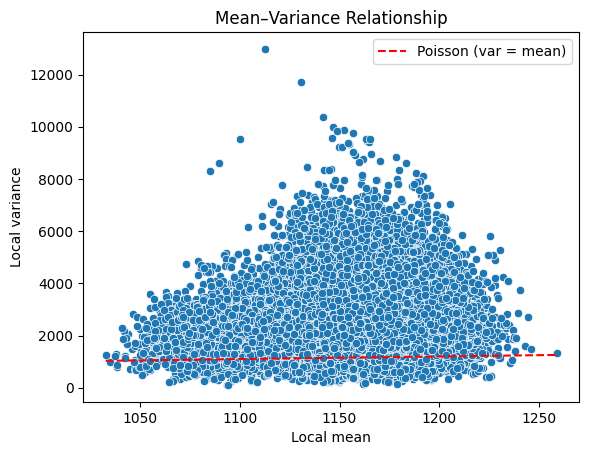

In [112]:
satellite_data = satellite_data_dict["1s"]
bins = 10
n_det = 1

for i in range(n_detectors):
    counts = satellite_data[f"{target_count_str}{i+1}"]
    mean_c = counts.mean()
    var_c  = counts.var(ddof=1)
    phi = var_c / mean_c
    print(f"Detector {i+1}: mean={mean_c:.2f}, var/mean={phi:.3f}")
print()

# Each point is a local window of N bins
# - get local mean/var arrays
counts = satellite_data[f"{target_count_str}{n_det}"]
x = counts.rolling(bins).mean()
y = counts.rolling(bins).var()

# scatter
sns.scatterplot(x=x, y=y)

# diagonal Poisson line: y = x
m, M = np.nanmin(x), np.nanmax(x)
plt.plot([m, M], [m, M], 'r--', label='Poisson (var = mean)')

plt.xlabel("Local mean")
plt.ylabel("Local variance")
plt.title("Mean–Variance Relationship")
plt.legend()
plt.show()


> The observed variance is several times larger than the Poisson expectation, in particular around the average count.
>
> A plain Poisson regression will systematically underestimate uncertainty and produce biased λ estimates.
>
>> Larger windows blend distinct states and inflate variance.

## Regressing
Recall: our goal is to predict the per-bin expected probability distribution of photon counts. The input features woud be the satellite metadata and the output would be a background distribution. The ground truths would be the raw count rates in the dataframe.

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tf_keras.models import Sequential
from tf_keras.layers import Dense, Input, Conv1D, Activation, Dropout, LayerNormalization, Concatenate
from tf_keras.models import Model
import tensorflow_probability as tfp
import tensorflow as tf

tf.random.set_seed(42)
np.random.seed(42)

### Train-Val-Test split

In [62]:
input_features = ["x_lat", "x_lon", "z_lat", "z_lon",
                  "altitude(km)", "Earth_lat", "Earth_lon"]
target_features = [f"{target_count_str}{i+1}" for i in range(6)]

# Choose df resolution
df_name = "1s"
satellite_data = satellite_data_dict[df_name]

# Standard IID split for training (random)
X_train, X_test, y_train, y_test = train_test_split(
    satellite_data[input_features],
    satellite_data[target_features],
    test_size=0.15,
    random_state=42,
    shuffle=True
)

#  Separate contiguous segment for "temporal" test
#    example: last 5% of the time-ordered dataset
test_fraction = 0.15
n_total = len(satellite_data)
n_contig = int(n_total * test_fraction)

X_test_contig = satellite_data[input_features].iloc[-n_contig:]
y_test_contig = satellite_data[target_features].iloc[-n_contig:]

# make sure the train set doesn't overlap
X_train = satellite_data[input_features].iloc[:-n_contig]
y_train = satellite_data[target_features].iloc[:-n_contig]


In [63]:
print(f"X_train shape:\t\t{X_train.shape}")
print(f"X_test shape:\t\t{X_test.shape}")
print(f"X_test_contig shape:\t{X_test_contig.shape}")
print(f"y_test_contig shape:\t{y_test_contig.shape}")
print(f"y_train shape:\t\t{y_train.shape}")
print(f"y_test shape:\t\t{y_test.shape}")

X_train shape:		(28735, 7)
X_test shape:		(5071, 7)
X_test_contig shape:	(5070, 7)
y_test_contig shape:	(5070, 6)
y_train shape:		(28735, 6)
y_test shape:		(5071, 6)


### Normalizing input features
Crucial step in a Machine Learning process. In this case, it is even more important, since the metadata features lie in a excessively big scale (~$1e^{16}$).

In [64]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<a name="fit_distrib"></a>
### Fitting Distributions
In order to train our probabilistic regressor, we have to first define the underlying probability distribution of our count rates, the ground truth of our background forecasting process.

As we have seen in the previous [subsection](#countrate_distrib), we will split our data in sequences of **500s** windows, to avoid orbital trends.

Now, we will proceed to try to fit different probability distributions to our data in order to find the one that fits the most.

1. We try to fit the Poisson distribution to each of our window, to see whether it can be a reasonable fit, according to our theoretical assumptions.

2. Then, we will fit several continuous distributions that essentially approximates

In [65]:
from scipy import stats

candidates = {
    "norm": stats.norm,
    "skew_norm": stats.skewnorm,
    "laplace": stats.laplace,
    "gamma": stats.gamma,
    "lognorm": stats.lognorm,
    "invgauss": stats.invgauss,
    "weibull": stats.weibull_min,
    "gumbel_l": stats.gumbel_l,
    "gev": stats.genextreme
}

bin_sec = 1
window_bins = int(150 / bin_sec)
best_start, best_window = choose_best_window(window_bins, satellite_data_dict["1s"])
w = best_window

for det_idx in range(w.shape[1]): # Iterate through detectors (columns of w)
    print(f"=== Detector {det_idx} ===")
    fits = {}
    detector_data = w[:, det_idx] # Select data for the current detector

    for name, dist in candidates.items():
        try:
            params = dist.fit(detector_data) # Fit to the 1D data
            loglik = np.sum(dist.logpdf(detector_data, *params))
            k = len(params)
            aic = 2 * k - 2 * loglik
            fits[name] = (params, aic)
        except Exception as e:
            print(f"  ⚠️ {name} fit failed on Detector {det_idx}: {e}")
            continue
    if fits:
        best = min(fits, key=lambda k: fits[k][1])
        params = [round(float(x), 1) for x in fits[best][0]]
        print(f"  Detector {det_idx} best = {best:10s} | AIC = {fits[best][1]:.1f} | params = {params}")
    else:
        print(f"  No distributions could be fitted for Detector {det_idx}")

    print()

=== Detector 0 ===
  Detector 0 best = weibull    | AIC = 1618.8 | params = [2.2, 1042.0, 129.3]

=== Detector 1 ===
  Detector 1 best = norm       | AIC = 1634.1 | params = [1161.5, 55.4]

=== Detector 2 ===
  Detector 2 best = norm       | AIC = 1540.3 | params = [993.6, 40.5]

=== Detector 3 ===
  Detector 3 best = norm       | AIC = 1568.5 | params = [994.8, 44.5]

=== Detector 4 ===
  Detector 4 best = weibull    | AIC = 1542.7 | params = [3.7, 830.6, 147.3]

=== Detector 5 ===
  Detector 5 best = weibull    | AIC = 1544.0 | params = [2.6, 807.7, 112.9]



In [66]:
bin_sec = 1
window_bins = int(150 / bin_sec)

# Select only detector columns
detector_cols = [c for c in satellite_data_dict["1s"].columns if "det" in c.lower()]
satellite_data_det = satellite_data_dict["1s"][detector_cols].astype(float)

# Build windows
windows = windowing_data(satellite_data_det, 500*15)

results = []

for win_idx, w in enumerate(windows):
    print(f"\n=== Window {win_idx + 1}/{len(windows)} ===")
    w = w.reset_index(drop=True)

    for det_idx, col in enumerate(w.columns):  # now we have exactly 6 detectors
        fits = {}
        detector_data = w[col].dropna().astype(float).values

        print(f"\n  --- {col} ---")

        if len(detector_data) == 0 or np.all(detector_data == detector_data[0]):
            print("    ⚠️ Skipped (empty or constant data)")
            continue

        for name, dist in candidates.items():
            try:
                params = dist.fit(detector_data)
                loglik = np.sum(dist.logpdf(detector_data, *params))
                k = len(params)
                aic = 2 * k - 2 * loglik
                fits[name] = (params, aic)
            except Exception as e:
                # suppress repetitive errors
                print(f"    ⚠️ {name} fit failed: {e}")
                continue

        if fits:
            best = min(fits, key=lambda k: fits[k][1])
            params = [round(float(x), 2) for x in fits[best][0]]
            print(f"    ✅ Best = {best:10s} | AIC = {fits[best][1]:.2f} | params = {params}")
            results.append({
                "window": win_idx,
                "detector": col,
                "best_dist": best,
                "aic": fits[best][1],
                "params": params
            })
        else:
            print(f"    ❌ No distributions could be fitted.")

results_df = pd.DataFrame(results)
print("\nSummary of best fits:")
print(results_df.head())



=== Window 1/5 ===

  --- rates_det_1 ---
    ✅ Best = weibull    | AIC = 81388.28 | params = [3.59, 976.51, 198.38]

  --- rates_det_2 ---
    ✅ Best = weibull    | AIC = 81470.17 | params = [3.25, 992.96, 183.48]

  --- rates_det_3 ---
    ✅ Best = weibull    | AIC = 78826.69 | params = [3.12, 851.25, 148.58]

  --- rates_det_4 ---
    ✅ Best = skew_norm  | AIC = 78930.42 | params = [-0.62, 1014.46, 51.43]

  --- rates_det_5 ---
    ✅ Best = weibull    | AIC = 77935.70 | params = [3.44, 809.86, 151.68]

  --- rates_det_6 ---
    ✅ Best = weibull    | AIC = 76694.27 | params = [3.26, 795.21, 133.59]

=== Window 2/5 ===

  --- rates_det_1 ---
    ✅ Best = weibull    | AIC = 81937.74 | params = [3.7, 962.67, 210.78]

  --- rates_det_2 ---
    ✅ Best = weibull    | AIC = 81786.85 | params = [3.41, 982.46, 194.78]

  --- rates_det_3 ---
    ✅ Best = weibull    | AIC = 79404.87 | params = [3.29, 847.32, 160.79]

  --- rates_det_4 ---
    ✅ Best = weibull    | AIC = 79544.96 | params = [3.

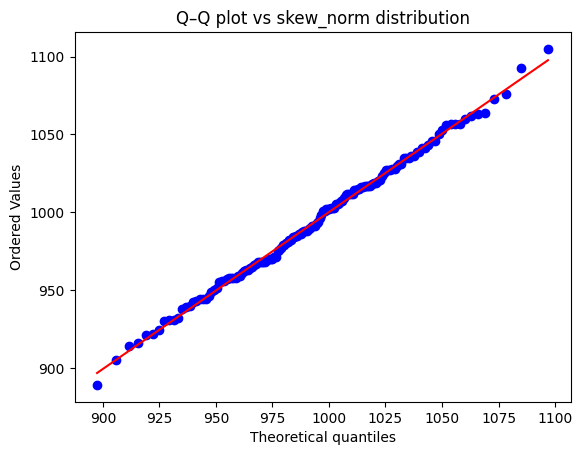

In [67]:
# Count rate data
data = best_window[:, 2]

# Fit the skew-normal distribution to the data
params = stats.weibull_min.fit(data)

# Q-Q plot against skew-normal distribution with fitted parameters
stats.probplot(data, dist="weibull_min", sparams=params, plot=plt)
plt.title("Q–Q plot vs skew_norm distribution")
plt.show()

> Although the underlying physical process is expected to follow a Poisson distribution, we consider a rate of counts, which distribution becomes approximately a Normal for big N's. Indeed,

### Baselines

In [68]:
def nll(y_true, dist):
    return -tf.reduce_mean(dist.log_prob(y_true))

In [69]:
def custom_mae(y_true, y_pred):
    n_detectors = y_train.shape[1]
    mu = y_pred[:, :n_detectors]
    return tf.reduce_mean(tf.abs(y_true - mu))

In [70]:
from tensorflow.keras.optimizers import AdamW

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=7e-3,
    decay_steps=200,
    decay_rate=0.95
)

optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

##### Deterministic Regressor

In [71]:
def build_regressor(n_input_features, initial_units = 512,
                    flat = False, num_layers = 3,
                    n_detectors = 6):
  # Input
  input = Input(shape=(n_input_features,))
  x = input

  # Hidden
  hidden_units = []
  for i in range(num_layers):
      if not flat:
          # progressively smaller
          units = initial_units // (2**i)
      else:
          # flat tail logic: last = previous (only if >=3 layers)
          if num_layers >= 3 and i == num_layers - 1 and len(hidden_units) > 0:
              units = hidden_units[-1]  # repeat previous
          else:
              units = initial_units // (2**i)
      hidden_units.append(units)
      x = Dense(units, activation="relu")(x)

  output = Dense(n_detectors, activation = "linear")(x)

  regressor = Model(inputs=input, outputs=output)
  return regressor

#### Poisson Regressor
Let's start with a straightforward **dense** FFN.

In [72]:
def build_poisson_regressor(n_input_features, initial_units = 512,
                            flat = False, num_layers = 3,
                            rate_guess = 1, mean_count=1000,
                            n_detectors = 6):
  # Input
  input = Input(shape=(n_input_features,))
  x = input

  # Hidden
  hidden_units = []
  for i in range(num_layers):
      if not flat:
          # progressively smaller
          units = initial_units // (2**i)
      else:
          # flat tail logic: last = previous (only if >=3 layers)
          if num_layers >= 3 and i == num_layers - 1 and len(hidden_units) > 0:
              units = hidden_units[-1]  # repeat previous
          else:
              units = initial_units // (2**i)
      hidden_units.append(units)
      x = Dense(units, activation="relu",
          kernel_regularizer=tf.keras.regularizers.l2(1e-2))(x)

  x = Dropout(0.5)(x)

  # Predict distribution parameters
  log_rate = Dense(n_detectors, activation = "linear",
                   bias_initializer=tf.keras.initializers.Constant(np.log(mean_count)))(x)

  # Create a lambda function and model output
  # - t is log_rate
  # - we predict the log of lambda because we want positive values
  # - then we recover back lambda exp. it
  lf = lambda t: tfp.distributions.Poisson(rate = tf.clip_by_value(rate_guess * tf.exp(t), 1e-3, 3e4))
  output = tfp.layers.DistributionLambda(lf)(log_rate) # model output = distribution

  regressor = Model(inputs=input, outputs=output)
  return regressor

#### Continuous Regressors

In [73]:
def build_lognorm_regressor(n_input_features, n_detectors=6,
                            initial_units=512, num_layers=3):
    inp = Input(shape=(n_input_features,))
    x = inp
    for i in range(num_layers):
        x = Dense(initial_units // (2**i), activation="relu")(x)

    x = Dropout(0.5)(x)

    mu = Dense(n_detectors, activation="linear", name="mu")(x)
    log_sigma = Dense(n_detectors, activation="linear", name="log_sigma")(x)

    def make_dist(t):
        mu, log_sigma = tf.split(t, 2, axis=-1)
        sigma = tf.nn.softplus(log_sigma) + 1e-6
        return tfp.distributions.Independent(
            tfp.distributions.LogNormal(loc=mu, scale=sigma),
            reinterpreted_batch_ndims=1)

    out = tfp.layers.DistributionLambda(make_dist)(
        Concatenate()([mu, log_sigma])
    )

    return Model(inp, out)


def build_normal_regressor(n_input_features,
                           initial_units=512,
                           flat=False,
                           num_layers=3,
                           mean_rate=1000,
                           n_detectors=6):
    """
    Normal (Gaussian) regressor analogous to Poisson/Gamma/Weibull versions.
    Predicts mean (mu) and stddev (sigma) for each detector.
    """

    # Input
    inputs = Input(shape=(n_input_features,))
    x = inputs

    # Hidden layers
    hidden_units = []
    for i in range(num_layers):
        if not flat:
            units = initial_units // (2 ** i)
        else:
            if num_layers >= 3 and i == num_layers - 1 and len(hidden_units) > 0:
                units = hidden_units[-1]
            else:
                units = initial_units // (2 ** i)
        hidden_units.append(units)
        x = Dense(units, activation="relu")(x)

    x = Dropout(0.5)(x)

    # Predict mean and log stddev
    mu = Dense(
        n_detectors,
        activation="linear",
        bias_initializer=tf.keras.initializers.Constant(np.log(mean_rate)),
        name="mu"
    )(x)

    log_sigma = Dense(
        n_detectors,
        activation="linear",
        bias_initializer=tf.keras.initializers.Constant(np.log(10.0)),
        name="log_sigma"
    )(x)

    params = Concatenate(axis=-1)([mu, log_sigma])

    # Distribution definition
    def make_normal(t):
        mu, log_sigma = tf.split(t, num_or_size_splits=2, axis=-1)
        sigma = tf.nn.softplus(log_sigma) + 1e-6
        sigma = tf.clip_by_value(sigma, 1e-6, 1e5)
        return tfp.distributions.Independent(
            tfp.distributions.Normal(loc=mu, scale=sigma),
            reinterpreted_batch_ndims=1
        )

    output = tfp.layers.DistributionLambda(make_normal)(params)

    model = Model(inputs=inputs, outputs=output)
    return model


In [74]:
def build_weibull_regressor(n_input_features,
                            initial_units=512,
                            flat=False,
                            num_layers=3,
                            mean_rate=1000,     # average rate in your data
                            n_detectors=6):
    """
    Weibull regressor analogous to the Poisson version.
    Predicts shape (k) and scale (lambda) for each detector.
    """

    # Input
    inputs = Input(shape=(n_input_features,))
    x = inputs

    # Hidden layers
    hidden_units = []
    for i in range(num_layers):
        if not flat:
            units = initial_units // (2 ** i)
        else:
            if num_layers >= 3 and i == num_layers - 1 and len(hidden_units) > 0:
                units = hidden_units[-1]
            else:
                units = initial_units // (2 ** i)
        hidden_units.append(units)
        x = Dense(units, activation="relu")(x)

    # Predict log parameters (for positivity)
    log_k = Dense(n_detectors, activation="linear",
                  bias_initializer=tf.keras.initializers.Constant(np.log(2.0)),
                  name="log_k")(x)        # shape (k)
    log_lambda = Dense(n_detectors, activation="linear",
                       bias_initializer=tf.keras.initializers.Constant(np.log(mean_rate)),
                       name="log_lambda")(x)  # scale (lambda)

    # Combine the two outputs
    params = tf.keras.layers.Concatenate(axis=-1)([log_k, log_lambda])

    # Define the distribution
    def make_weibull(t):
        log_k, log_lambda = tf.split(t, num_or_size_splits=2, axis=-1)
        k = tf.nn.softplus(log_k) + 1e-6         # ensure positive
        lam = tf.nn.softplus(log_lambda) + 1e-6  # ensure positive
        lam = tf.clip_by_value(lam, 1e-3, 3e5)   # prevent overflow

        return tfp.distributions.Independent(
            tfp.distributions.Weibull(concentration=k, scale=lam),
            reinterpreted_batch_ndims=1
        )

    output = tfp.layers.DistributionLambda(make_weibull)(params)

    regressor = Model(inputs=inputs, outputs=output)
    return regressor


def build_gamma_regressor(n_input_features,
                          initial_units=512,
                          flat=False,
                          num_layers=3,
                          mean_rate=1000,
                          n_detectors=6):
    """
    Gamma regressor analogous to the Poisson one.
    Predicts concentration (alpha) and rate (beta) parameters for each detector.
    """

    # Input
    inputs = Input(shape=(n_input_features,))
    x = inputs

    # Hidden layers
    hidden_units = []
    for i in range(num_layers):
        if not flat:
            units = initial_units // (2 ** i)
        else:
            if num_layers >= 3 and i == num_layers - 1 and len(hidden_units) > 0:
                units = hidden_units[-1]
            else:
                units = initial_units // (2 ** i)
        hidden_units.append(units)
        x = Dense(units, activation="relu")(x)

    # Output heads (log-parameters)
    log_alpha = Dense(
        n_detectors,
        activation="linear",
        bias_initializer=tf.keras.initializers.Constant(np.log(2.0)),
        name="log_alpha"
    )(x)

    log_beta = Dense(
        n_detectors,
        activation="linear",
        bias_initializer=tf.keras.initializers.Constant(np.log(mean_rate / 2.0)),
        name="log_beta"
    )(x)

    params = Concatenate(axis=-1)([log_alpha, log_beta])

    # Define the distribution
    def make_gamma(t):
        log_alpha, log_beta = tf.split(t, num_or_size_splits=2, axis=-1)
        alpha = tf.nn.softplus(log_alpha) + 1e-6   # concentration (shape)
        beta = tf.nn.softplus(log_beta) + 1e-6     # rate (1/scale)
        beta = tf.clip_by_value(beta, 1e-6, 1e6)

        return tfp.distributions.Independent(
            tfp.distributions.Gamma(concentration=alpha, rate=beta),
            reinterpreted_batch_ndims=1
        )

    output = tfp.layers.DistributionLambda(make_gamma)(params)

    model = Model(inputs=inputs, outputs=output)
    return model


In [75]:
tfd = tfp.distributions

# Custom class definition
class SkewNormal(tfp.distributions.Distribution):
    def __init__(self, loc, scale, skewness, validate_args=False, allow_nan_stats=True, name="SkewNormal"):
        parameters = dict(locals())
        self.loc = tf.convert_to_tensor(loc, dtype=tf.float32)
        self.scale = tf.convert_to_tensor(scale, dtype=tf.float32)
        self.skewness = tf.convert_to_tensor(skewness, dtype=tf.float32)
        self.normal = tfd.Normal(loc=0.0, scale=1.0)  # Standard normal

        super(SkewNormal, self).__init__(
            dtype=tf.float32,
            reparameterization_type=tfd.NOT_REPARAMETERIZED,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            parameters=parameters,
            name=name.replace(" ", "_"),
        )

    # Log-probability density function (PDF) of the Skew-Normal distribution.
    def _log_prob(self, value):
        z = (value - self.loc) / self.scale
        normal_log_prob = self.normal.log_prob(z)
        skew_factor = 2 * self.normal.cdf(self.skewness * z)

        # Ensure numerical stability
        skew_factor = tf.clip_by_value(skew_factor, 1e-6, 1.0)  # Avoid log(0)
        return normal_log_prob + tf.math.log(skew_factor) - tf.math.log(self.scale)

    # --- Mean ---
    def _mean(self):
        # δ = α / sqrt(1 + α²)
        delta = self.skewness / tf.sqrt(1.0 + tf.square(self.skewness))
        # E[X] = μ + σ * δ * sqrt(2/π)
        mean = self.loc + self.scale * delta * tf.sqrt(2.0 / tf.constant(3.141592653589793, dtype=tf.float32))
        return mean

    # --- Variance ---
    def _variance(self):
        delta = self.skewness / tf.sqrt(1.0 + tf.square(self.skewness))
        var = self.scale**2 * (1.0 - (2.0 * delta**2) / tf.constant(3.141592653589793, dtype=tf.float32))
        return var

    # --- Sampling (for completeness) ---
    def _sample_n(self, n, seed=None):
        # Sample from standard normal
        u0 = tf.random.normal(shape=(n,) + tf.shape(self.loc), seed=seed)
        v = tf.random.normal(shape=(n,) + tf.shape(self.loc), seed=seed)
        # Apply skew transformation
        delta = self.skewness / tf.sqrt(1.0 + tf.square(self.skewness))
        u1 = delta * tf.abs(u0) + tf.sqrt(1.0 - delta**2) * v
        return self.loc + self.scale * u1

def model_predict_fn(X):
  # Predict parameters
  y_pred = model(X)
  n_detectors = y_pred.shape[1] // 3

  mu    = y_pred[:, :n_detectors]
  sigma = tf.nn.softplus(y_pred[:, n_detectors:2*n_detectors]) + 1e-3
  alpha = y_pred[:, 2*n_detectors:]

  # Build distribution
  sn_dist = SkewNormal(loc=mu, scale=sigma, skewness=alpha)

  # Return expected mean for your chosen detector
  return sn_dist.mean().numpy()[:, det_idx - 1]


# Negative Log-Likelihood for the Skew-Normal distribution.
def skew_normal_nll(y_true, y_pred):
    n_detectors = y_true.shape[-1]
    mu = y_pred[:, :n_detectors]
    sigma = y_pred[:, n_detectors:2*n_detectors]
    alpha = y_pred[:, 2*n_detectors:]

    sn = SkewNormal(loc=mu, scale=sigma, skewness=alpha)
    return -tf.reduce_mean(sn.log_prob(y_true))

def build_skewnorm_regressor(n_input_features, initial_units = 512,
                             flat = False, num_layers = 3,
                             n_detectors = 6):
  # Input
  input = Input(shape=(n_input_features,))
  x = input

  # Hidden
  hidden_units = []
  for i in range(num_layers):
      if not flat:
          # progressively smaller
          units = initial_units // (2**i)
      else:
          # flat tail logic: last = previous (only if >=3 layers)
          if num_layers >= 3 and i == num_layers - 1 and len(hidden_units) > 0:
              units = hidden_units[-1]  # repeat previous
          else:
              units = initial_units // (2**i)
      hidden_units.append(units)
      x = Dense(units, activation="relu")(x)

  # Predict distribution parameters
  mu = Dense(n_detectors, activation = "linear")(x)
  sigma = Dense(n_detectors, activation = "softplus")(x)
  alpha = Dense(n_detectors, activation = "linear")(x)

  output = Concatenate(axis=-1)([mu, sigma, alpha])

  regressor = Model(inputs=input, outputs=output)
  return regressor

#### Training

In [76]:
from tf_keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
]

n_input_features = X_train_scaled.shape[1]
best_config = {"units": 128, "num_hidden": 2, "batch_size": 64, "flat": True}

###### GridSearch

In [77]:
from itertools import product

n_input_features = X_train_scaled.shape[1]
n_detectors = y_train.shape[1]

# Hyperparams
dense_params = {
    "units": [512, 256, 128],
    "num_hidden": [2, 3, 4],
    "batch_size": [4, 8],
    "flat": [True, False]
}

def gridsearch(models, dense_params):
    results_search = []

    for model in models:
        print(f"Training model: {model}")
        param_space = list(product(*dense_params.values()))
        param_keys = list(dense_params.keys())

        for param_tuple in param_space:
            param = {param_keys[i]: param_tuple[i] for i in range(len(param_tuple))}
            print(f"Parameter config: {param}")

            model = build_poisson_regressor(n_input_features=n_input_features,
                                            initial_units=param["units"],
                                            num_layers=param["num_hidden"],
                                            flat=param["flat"],
                                            n_detectors=n_detectors)

            model.compile(optimizer="adam",
                          loss=nll,
                          metrics = [custom_mae])

            history = model.fit(x=X_train_scaled, y=y_train,
                                validation_split=0.10,
                                epochs=200, batch_size=param["batch_size"],
                                callbacks=callbacks, verbose=0)

            val_loss = history.history['val_loss'][-1]
            val_mae = history.history['val_custom_mae'][-1]
            result = {**param, 'model': model, 'val_loss': val_loss,
                      "val_mae": val_mae}
            results_search.append(result)

    return results_search

In [78]:
def select_best_config(results_search):
  df_results_search = pd.DataFrame(results_search)
  best_config_val_loss = df_results_search.loc[df_results_search['val_loss'].idxmin()]
  return best_config_val_loss

In [79]:
#results_search = gridsearch(["dense_regressor"], dense_params)
#best_config = select_best_config(results_search)

#print(f"Best configuration:\n {best_config}")

In [80]:
#best_config = select_best_config(results_search)
#print("Best configuration:")
#display(pd.DataFrame(best_config).drop(["model"]).T)

In [81]:
#res_gs = pd.DataFrame(results_search)
#res_gs.to_csv("/content/drive/MyDrive/Colab Notebooks/Internship + Thesis/data/res_gs.csv", index=False)

In [82]:
# for future runs
#best_config = {"units": 64, "num_hidden": 2, "batch_size": 4, "flat": False}

###### 1s data

In [83]:
skewnorm_regressor = build_skewnorm_regressor(n_input_features = n_input_features,
                                          initial_units = best_config["units"],
                                          num_layers = best_config["num_hidden"],
                                          n_detectors = n_detectors)

skewnorm_regressor.compile(optimizer = "adam",
                  loss = skew_normal_nll,
                  metrics = [custom_mae])

history_sn = skewnorm_regressor.fit(x = X_train_scaled, y = y_train,
                            validation_split = 0.10,
                            epochs = 150, batch_size = best_config["batch_size"],
                            callbacks=callbacks, verbose=1)

Epoch 1/150
405/405 [==============================] - 2s 2ms/step - loss: 64350.5703 - custom_mae: 1019.4147 - val_loss: 5233.3188 - val_custom_mae: 1008.6688
Epoch 2/150
405/405 [==============================] - 1s 2ms/step - loss: 2832.1775 - custom_mae: 1002.5178 - val_loss: 2100.9829 - val_custom_mae: 990.9949
Epoch 3/150
405/405 [==============================] - 1s 2ms/step - loss: 1346.7299 - custom_mae: 983.1846 - val_loss: 1180.7429 - val_custom_mae: 970.9965
Epoch 4/150
405/405 [==============================] - 1s 2ms/step - loss: 808.5032 - custom_mae: 961.4145 - val_loss: 763.5353 - val_custom_mae: 948.7689
Epoch 5/150
405/405 [==============================] - 1s 2ms/step - loss: 539.1854 - custom_mae: 937.2458 - val_loss: 531.6325 - val_custom_mae: 924.2097
Epoch 6/150
405/405 [==============================] - 1s 3ms/step - loss: 381.2069 - custom_mae: 910.7212 - val_loss: 387.0177 - val_custom_mae: 897.1322
Epoch 7/150
405/405 [==============================] - 1s 2m

In [84]:
'''poiss_regressor = build_poisson_regressor(n_input_features = n_input_features,
                                          initial_units = best_config["units"],
                                          num_layers = best_config["num_hidden"],
                                          flat = best_config["flat"],
                                          n_detectors = n_detectors)

def quasi_poisson_nll(y_true, dist, phi=2.5):
    return -tf.reduce_mean(dist.log_prob(y_true)) / phi

poiss_regressor.compile(optimizer = "adam",
                  loss = quasi_poisson_nll,
                  metrics = [custom_mae])

history_p = poiss_regressor.fit(x = X_train_scaled, y = y_train,
                            validation_split = 0.10,
                            epochs = 150, batch_size = best_config["batch_size"],
                            callbacks=callbacks, verbose=1)'''

'poiss_regressor = build_poisson_regressor(n_input_features = n_input_features,\n                                          initial_units = best_config["units"],\n                                          num_layers = best_config["num_hidden"],\n                                          flat = best_config["flat"],\n                                          n_detectors = n_detectors)\n\ndef quasi_poisson_nll(y_true, dist, phi=2.5):\n    return -tf.reduce_mean(dist.log_prob(y_true)) / phi\n\npoiss_regressor.compile(optimizer = "adam",\n                  loss = quasi_poisson_nll,\n                  metrics = [custom_mae])\n\nhistory_p = poiss_regressor.fit(x = X_train_scaled, y = y_train,\n                            validation_split = 0.10,\n                            epochs = 150, batch_size = best_config["batch_size"],\n                            callbacks=callbacks, verbose=1)'

In [85]:
'''weibull_regressor = build_weibull_regressor(n_input_features = n_input_features,
                                            initial_units = best_config["units"],
                                            num_layers = best_config["num_hidden"],
                                            flat = best_config["flat"],
                                            n_detectors = n_detectors)

weibull_regressor.compile(optimizer = "adam",
                          loss = nll,
                          metrics = [custom_mae])

history_w = weibull_regressor.fit(x = X_train_scaled, y = y_train,
                                  validation_split = 0.10,
                                  epochs = 150, batch_size = best_config["batch_size"],
                                  callbacks=callbacks, verbose=1)'''

'weibull_regressor = build_weibull_regressor(n_input_features = n_input_features,\n                                            initial_units = best_config["units"],\n                                            num_layers = best_config["num_hidden"],\n                                            flat = best_config["flat"],\n                                            n_detectors = n_detectors)\n\nweibull_regressor.compile(optimizer = "adam",\n                          loss = nll,\n                          metrics = [custom_mae])\n\nhistory_w = weibull_regressor.fit(x = X_train_scaled, y = y_train,\n                                  validation_split = 0.10,\n                                  epochs = 150, batch_size = best_config["batch_size"],\n                                  callbacks=callbacks, verbose=1)'

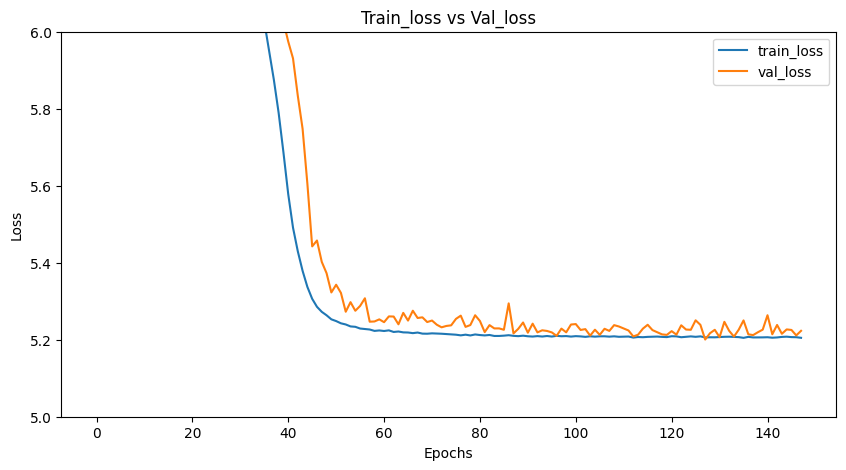

In [86]:
history = history_sn.history
plt.figure(figsize=(10, 5))

plt.plot(history['loss'], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")

# Set y-axis limits to zoom in
y_min = 5
y_max = 6
plt.ylim(y_min, y_max)

plt.legend()
plt.title("Train_loss vs Val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

##### Evaluation

In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [88]:
# Choose model
model = skewnorm_regressor

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred = y_pred[:, :n_detectors]

# Number of detectors
n_detectors = y_train.shape[1]

rmse = np.sqrt(np.mean((y_test - y_pred)**2, axis=0))
mae = np.mean(np.abs(y_test - y_pred), axis=0)
r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
perc_error = np.mean(np.abs(y_test - y_pred) / y_test)

print(f"R2 score: {r2}\n")
print(f"MAE per detector:\n{mae}\n")
print(f"RMSE per detector:\n{rmse}\n")
print(f"Percentage error: {perc_error*100:.2f}%")

159/159 [==============================] - 0s 844us/step
R2 score: 0.17451266944408417

MAE per detector:
rates_det_1    41.185647
rates_det_2    40.619221
rates_det_3    32.580742
rates_det_4    32.497608
rates_det_5    32.201208
rates_det_6    31.542760
dtype: float64

RMSE per detector:
rates_det_1    51.330577
rates_det_2    50.834086
rates_det_3    40.747726
rates_det_4    40.585431
rates_det_5    40.235200
rates_det_6    39.467473
dtype: float64

Percentage error: 3.42%


In [89]:
'''# Choose model
model = poiss_regressor

# Make predictions
y_pred = model.predict(X_test_scaled)

# Number of detectors
n_detectors = y_train.shape[1]

rmse = np.sqrt(np.mean((y_test - y_pred)**2, axis=0))
mae = np.mean(np.abs(y_test - y_pred), axis=0)
r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
perc_error = np.mean(np.abs(y_test - y_pred) / y_test)

print(f"R2 score: {r2}\n")
print(f"MAE per detector:\n{mae}\n")
print(f"RMSE per detector:\n{rmse}\n")
print(f"Percentage error: {perc_error*100:.2f}%")'''

'# Choose model\nmodel = poiss_regressor\n\n# Make predictions\ny_pred = model.predict(X_test_scaled)\n\n# Number of detectors\nn_detectors = y_train.shape[1]\n\nrmse = np.sqrt(np.mean((y_test - y_pred)**2, axis=0))\nmae = np.mean(np.abs(y_test - y_pred), axis=0)\nr2 = r2_score(y_test, y_pred, multioutput=\'uniform_average\')\nperc_error = np.mean(np.abs(y_test - y_pred) / y_test)\n\nprint(f"R2 score: {r2}\n")\nprint(f"MAE per detector:\n{mae}\n")\nprint(f"RMSE per detector:\n{rmse}\n")\nprint(f"Percentage error: {perc_error*100:.2f}%")'

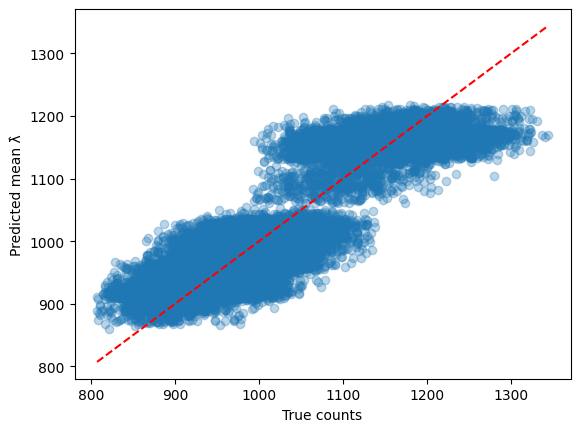

In [90]:
mu = y_pred.flatten()
y = y_test.values.flatten()
plt.scatter(y, mu, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True counts")
plt.ylabel("Predicted mean λ̂")
plt.show()

> The plot above shows how well the predictions are aligned with the true counts, following the ideal red line where the two counts type are equal. In particular, there is also a small spread.

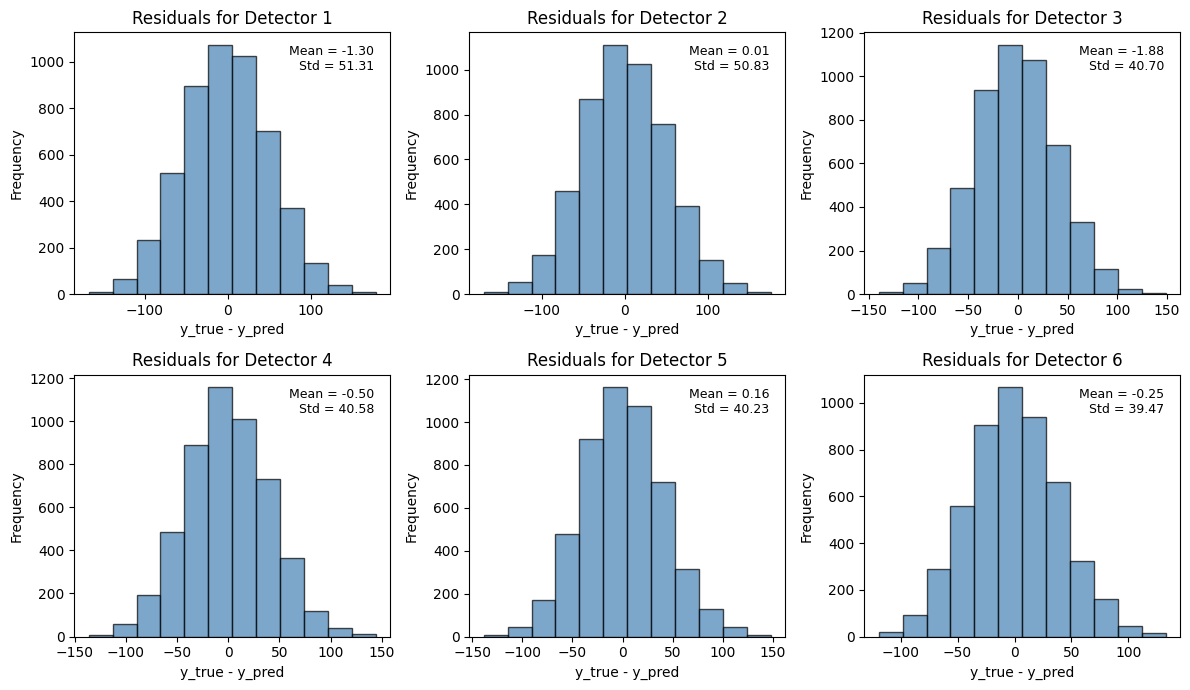

In [91]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))
residuals_per_det = []

for i, det_idx in enumerate(range(n_detectors)):
    residuals = y_test[f"{target_count_str}{det_idx+1}"].values - y_pred[:, det_idx]
    residuals_per_det.append(residuals)

    row, col = divmod(det_idx, 3)  # Compute subplot position (2x3 grid)
    ax[row, col].hist(residuals, bins=12, alpha=0.7, color='steelblue', edgecolor='black')
    ax[row, col].set_title(f"Residuals for Detector {det_idx+1}")
    ax[row, col].set_xlabel("y_true - y_pred")
    ax[row, col].set_ylabel("Frequency")

    # Compute stats
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)

    # Add text box with mean and std
    textstr = f"Mean = {mean_res:.2f}\nStd = {std_res:.2f}"
    ax[row, col].text(
        0.95, 0.95, textstr,
        transform=ax[row, col].transAxes,
        fontsize=9,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

plt.tight_layout()
plt.show()


> As we can see, the residuals approximately follow a roughly normal distribution centered around a positive number above 0. This indicates that the model is more than mildly accurate and **unbiased** (it doesn’t systematically over- or under-predict) and that its errors are randomly distributed, as expected for a well-fitted regression model. In other words, the predicted count rates closely match the true ones, with deviations that behave like natural random noise rather than structured bias.

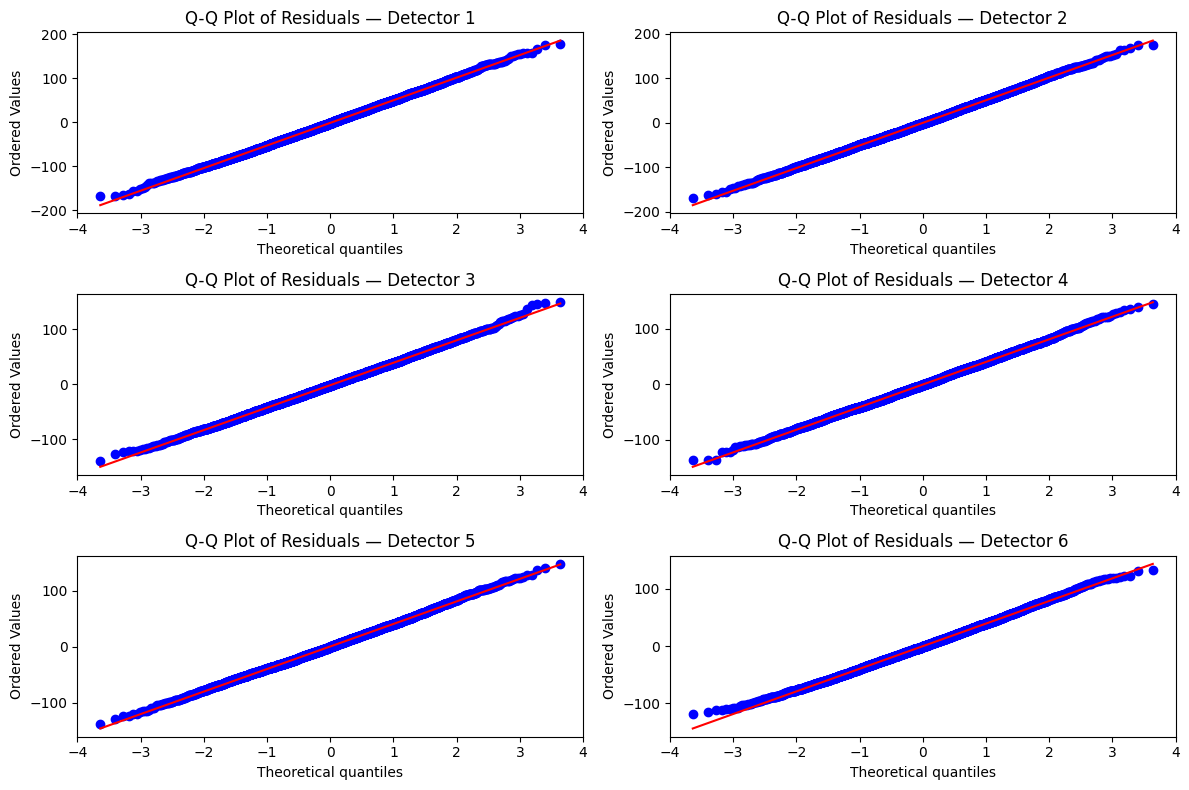

In [92]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

for det_idx in range(n_detectors):
  residuals = y_test[f"{target_count_str}{det_idx+1}"].values - y_pred[:, det_idx]
  row, col = divmod(det_idx, 2)
  stats.probplot(residuals, dist="norm", plot = ax[row, col])
  ax[row, col].set_title(f"Q-Q Plot of Residuals — Detector {det_idx+1}")

plt.tight_layout()
plt.show()

> The intuition above is confirmed by the Q-Q plot. All the residuals associated to different detectors approximately follow a normal distribution. This means that the predictions are **not biased**.

###### Plotting a test lightcurve


In [93]:
window_size = len(X_test_contig) # bins (~150 * 1s = 150s)
det_idx = 6
counts_col = f"{target_count_str}{det_idx}"

# Extract contiguous test data
y_full = y_test_contig[counts_col].values
X_full = X_test_contig[input_features]

# Scale using the SAME scaler fitted on training data
X_full_scaled = scaler.transform(X_full)

Weibull regressor

In [94]:
'''# Sliding-window evaluation
mae_list, rmse_list = [], []
window_indices = range(0, len(y_full) - window_size + 1, window_size)

for start in window_indices:
    end = start + window_size

    X_window = X_full_scaled[start:end]
    y_window = y_full[start:end]

    # Predict [WRONG!!! >:( ]
    #y_pred_w = model.predict(X_window)
    #y_pred_det = y_pred_w[:, det_idx-1]

    # Predict
    # - mean
    y_pred_dist = model(X_window)
    y_pred_mean = y_pred_dist.mean().numpy()
    y_pred_det = y_pred_mean[:, det_idx-1]
    # - std
    std = y_pred_dist.stddev().numpy()[:, det_idx-1]

    # Metrics
    mae = mean_absolute_error(y_window, y_pred_det)
    rmse = np.sqrt(mean_squared_error(y_window, y_pred_det))
    mae_list.append(mae)
    rmse_list.append(rmse)

    # Plot every N
    N = 1
    if start % (window_size * N) == 0:
      plt.figure(figsize=(15, 4))
      bins = np.arange(start, end)

      # True counts
      plt.step(bins, y_window, where="mid", label="True counts",
              linewidth=1.5, color="steelblue")

      # Predicted counts
      plt.step(bins, y_pred_det, where="mid", label="Predicted mean",
              linewidth=1.8, linestyle="--", color="darkorange")

      # Draw band
      k = 1
      lower = y_pred_det - k * std
      upper = y_pred_det + k * std

      plt.fill_between(
          bins,
          lower,
          upper ,
          color="orange",
          alpha=0.3,
          label=f"±{k}σ predicted uncertainty",
          zorder=3
      )

      # Count how many true points are inside [lower, upper]
      inside = (y_window >= lower) & (y_window <= upper)
      coverage = 100 * np.mean(inside)
      print(f"Fraction of true counts within ±{k}σ band: {coverage:.2f}%")

      # Label
      plt.title(
            "Weibull Regressor\n "
            f"Detector {det_idx} — Whole Contiguous Test Window {start // window_size + 1} "
            f"(bins {start}-{end})\n"f"MAE={mae:.2f}, RMSE={rmse:.2f}, "
            f"Coverage={coverage:.1f}%"
        )

      plt.xlabel("Time (bins)")
      plt.ylabel("Counts")
      plt.legend()
      plt.grid(alpha=0.3, linestyle=":")
      plt.tight_layout()
      plt.show()'''

'# Sliding-window evaluation\nmae_list, rmse_list = [], []\nwindow_indices = range(0, len(y_full) - window_size + 1, window_size)\n\nfor start in window_indices:\n    end = start + window_size\n\n    X_window = X_full_scaled[start:end]\n    y_window = y_full[start:end]\n\n    # Predict [WRONG!!! >:( ]\n    #y_pred_w = model.predict(X_window)\n    #y_pred_det = y_pred_w[:, det_idx-1]\n\n    # Predict\n    # - mean\n    y_pred_dist = model(X_window)\n    y_pred_mean = y_pred_dist.mean().numpy()\n    y_pred_det = y_pred_mean[:, det_idx-1]\n    # - std\n    std = y_pred_dist.stddev().numpy()[:, det_idx-1]\n\n    # Metrics\n    mae = mean_absolute_error(y_window, y_pred_det)\n    rmse = np.sqrt(mean_squared_error(y_window, y_pred_det))\n    mae_list.append(mae)\n    rmse_list.append(rmse)\n\n    # Plot every N\n    N = 1\n    if start % (window_size * N) == 0:\n      plt.figure(figsize=(15, 4))\n      bins = np.arange(start, end)\n\n      # True counts\n      plt.step(bins, y_window, where=

Plotting for skew norm

Fraction of true counts within ±1σ band: 66.88%


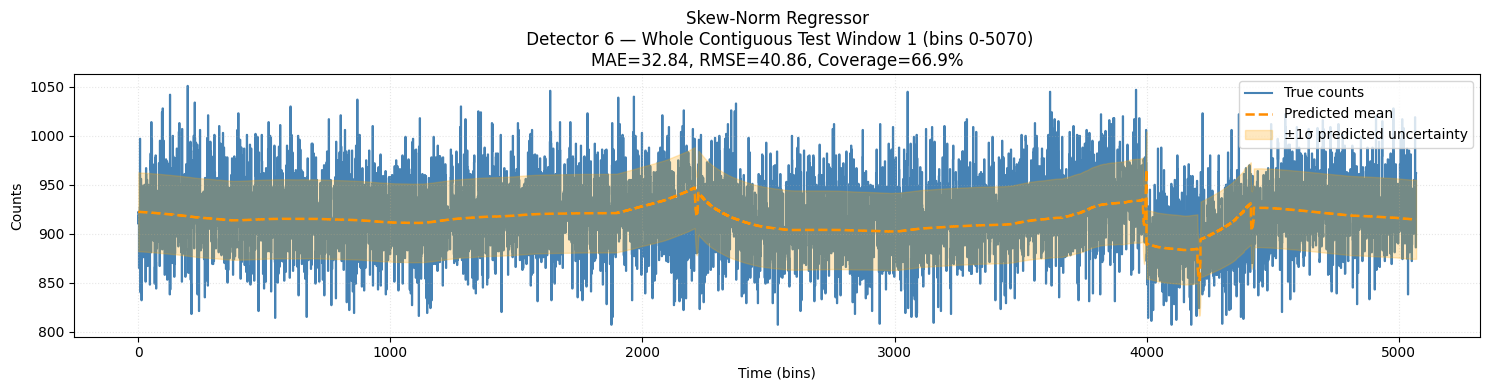

In [95]:
# Sliding-window evaluation
mae_list, rmse_list = [], []
window_indices = range(0, len(y_full) - window_size + 1, window_size)

for start in window_indices:
    end = start + window_size
    X_window = X_full_scaled[start:end]
    y_window = y_full[start:end]

    # --- Predict ---
    y_pred_w = model(X_window)
    n_detectors = y_pred_w.shape[1] // 3

    mu    = y_pred_w[:, :n_detectors]
    sigma = tf.nn.softplus(y_pred_w[:, n_detectors:2*n_detectors]) + 1e-3
    alpha = y_pred_w[:, 2*n_detectors:]

    # --- Build distribution ---
    sn_dist = SkewNormal(loc=mu, scale=sigma, skewness=alpha)
    y_pred_mean = sn_dist.mean().numpy()
    y_pred_std  = sn_dist.stddev().numpy()

    # Select detector
    y_pred_det = y_pred_mean[:, det_idx - 1]
    y_std_det  = y_pred_std[:, det_idx - 1]

    # --- Metrics ---
    mae = mean_absolute_error(y_window, y_pred_det)
    rmse = np.sqrt(mean_squared_error(y_window, y_pred_det))
    mae_list.append(mae)
    rmse_list.append(rmse)

    # --- Plot (every N windows) ---
    N = 1
    if start % (window_size * N) == 0:
        plt.figure(figsize=(15, 4))
        bins = np.arange(start, end)

        # True vs predicted
        plt.step(bins, y_window, where="mid",
                 label="True counts", linewidth=1.5, color="steelblue",zorder=1)
        plt.step(bins, y_pred_det, where="mid",
                 label="Predicted mean", linewidth=1.8,
                 linestyle="--", color="darkorange", zorder=2)

        # --- Uncertainty band (±kσ) ---
        k = 1
        lower = y_pred_det - k * y_std_det
        upper = y_pred_det + k * y_std_det

        plt.fill_between(
            bins, lower, upper,
            color="orange", alpha=0.25,
            label=f"±{k}σ predicted uncertainty", zorder=3
        )

        # --- Coverage (fraction of true points within band) ---
        inside = (y_window >= lower) & (y_window <= upper)
        coverage = 100 * np.mean(inside)
        print(f"Fraction of true counts within ±{k}σ band: {coverage:.2f}%")

        # --- Labels ---
        plt.title(
            "Skew-Norm Regressor\n "
            f"Detector {det_idx} — Whole Contiguous Test Window {start // window_size + 1} "
            f"(bins {start}-{end})\n"f"MAE={mae:.2f}, RMSE={rmse:.2f}, "
            f"Coverage={coverage:.1f}%"
        )
        plt.xlabel("Time (bins)")
        plt.ylabel("Counts")
        plt.legend()
        plt.grid(alpha=0.3, linestyle=":")
        plt.tight_layout()
        plt.show()

> The model seems at least to follow the true count trend. However, it doesn't seem to be very accurate.

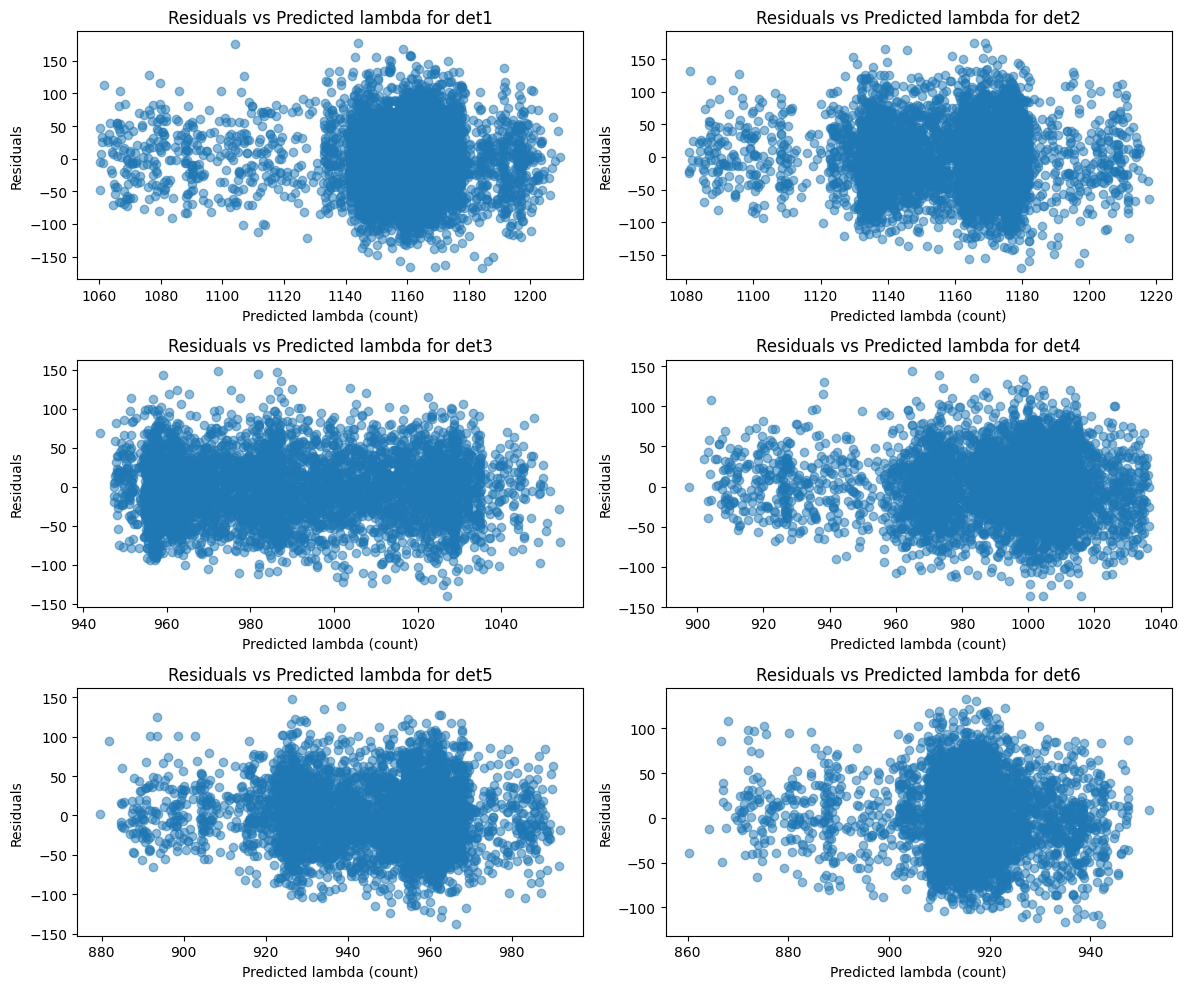

In [96]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for det_idx in range(n_detectors):
  residuals = y_test[f"{target_count_str}{det_idx+1}"].values - y_pred[:, det_idx]
  row, col = divmod(det_idx, 2)
  ax[row, col].scatter(y_pred[:, det_idx], residuals, alpha=0.5)
  ax[row, col].set_xlabel("Predicted lambda (count)")
  ax[row, col].set_ylabel("Residuals")
  ax[row, col].set_title(f"Residuals vs Predicted lambda for det{det_idx+1}")

plt.tight_layout()
plt.show()

> Here we are visualizing how variance changes as $λ$ varies, in particular at the **tails**. Indeed, we have extra variance both at low and high counts. That means the real data are slightly overdispersed, and the Poisson assumption (variance = mean) doesn’t hold perfectly across all ranges.

###### Checking the overdispersion degree

In [97]:
def check_dispersion(y_true, y_pred):
    """Return simple variance-to-mean and Pearson dispersion."""
    resid = y_true - y_pred
    var_obs = np.var(resid, ddof=1)
    mean_pred = np.mean(y_pred)
    phi_varmean = var_obs / mean_pred  # variance-to-mean ratio

    pearson_phi = np.mean((resid**2) / (y_pred + 1e-8))  # Pearson dispersion

    return phi_varmean, pearson_phi

for det in range(n_detectors):
    y_t = y_test[f"{target_count_str}{det+1}"].values
    y_p = y_pred[:, det]
    phi_vm, phi_p = check_dispersion(y_t, y_p)
    print(f"Detector {det+1}: Var/Mean = {phi_vm:.3f}, Pearson φ = {phi_p:.3f}")

Detector 1: Var/Mean = 2.277, Pearson φ = 2.277
Detector 2: Var/Mean = 2.231, Pearson φ = 2.228
Detector 3: Var/Mean = 1.673, Pearson φ = 1.676
Detector 4: Var/Mean = 1.661, Pearson φ = 1.660
Detector 5: Var/Mean = 1.710, Pearson φ = 1.708
Detector 6: Var/Mean = 1.701, Pearson φ = 1.700


> extra variance (Var/Mean ≈ 2–3) is likely due to missing explanatory variables or temporal dependence, not from the underlying distribution. NB, LogNormal, etc. don’t help — they assume that extra variance is random, not due to missing structure.

> It seems that each detector shows clear overdispersion. This means that our Poisson regressor underestimates uncertainty (variance), namely the predicted counts vary 2-3x more than a pure Poisson process predicts.
>
> The model fits the mean trend well, but can’t explain the extra stochastic variability between orbits or detectors.

### **Interpretability** through SHAP

1.   **Baseline computation**:
SHAP first establishes a reference prediction — the expected model output over a representative set of background (usually training) samples:
 $$\phi_0 = \dfrac{1}{N} ∑_{x\in background} f(x)$$
Conceptually, it represents what the model would predict if we had no information about the *specific* input sample.
In practice, this is equivalent to marginalizing over all possible feature values — an average prediction when all features are “unknown”.

2.   **Test prediction**:
 For each test sample $x_{test}$ compute $f(x_{test})$. This reflects the prediction the model makes when it has access to this sample’s actual feature values: $$f(x_{test}) = \phi_0 + ∑_i \phi_i$$

3.   **Shapley values**:
SHAP decomposes the difference between the sample’s prediction and the baseline:
$$f(x_{test}) - \phi_0 = ∑_i \phi_i$$
 Each feature $\phi_i$ quantifies **how much feature** $i$ contributed to shifting the prediction away from the baseline — positively or negatively.
In other words, Shapley values explain *why* the model’s prediction for a specific sample differs from what it would predict in general.



In [98]:
import shap

In [99]:
background = shap.sample(X_train_scaled, 100)
explainer = shap.KernelExplainer(model_predict_fn, background)

In [100]:
feature_names = list(input_features)  # original feature names
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)
shap_values = explainer(X_test_df)

  0%|          | 0/5071 [00:00<?, ?it/s]

In [101]:
idx_sample = 1

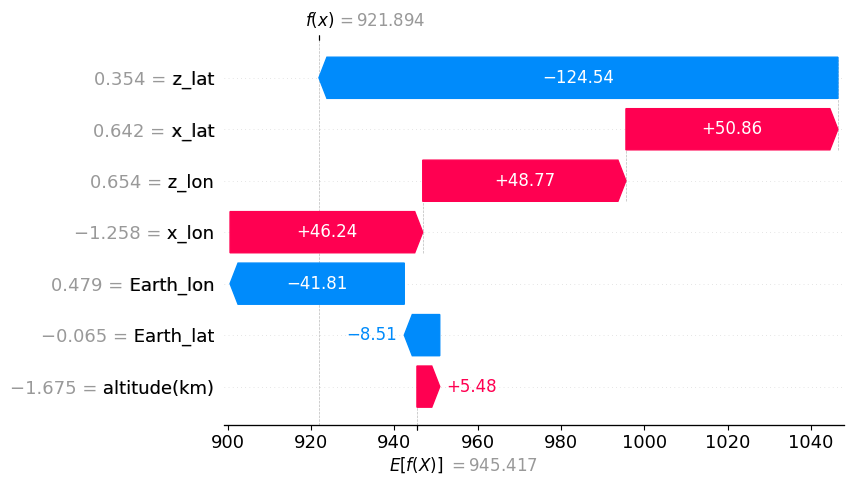

In [102]:
shap.plots.waterfall(shap_values[idx_sample])

> If we don't have access to any input feature, the predictions is supposed to be *~ 948* (the population average).
>
> Our current prediction is way lower than the population average (the baseline), and the Shapley values of each features tells us that the `z_lat` and `x_lon` features are the one that are the most impactful.

In [103]:
shap.initjs()
shap.plots.force(shap_values[idx_sample])

> This is a more compact plot of the waterfall plot, delivering the same info.

In [104]:
shap.initjs()
shap.plots.force(shap_values[-100:])

> The plot above shows the force plots for multiple test samples:
> - *x-axis:* the test sample
> - *y-axis:* the corresponding force plot
>
> Here there aren't clusters of samples that behave very differently among them, because they approximately follow the same behavior.

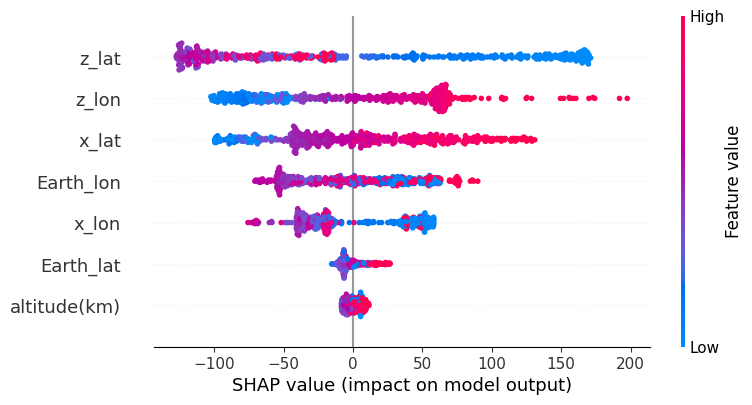

In [111]:
shap.plots.beeswarm(shap_values[-500:])

> There is a negative correlation between `z_lat` and its shapely values; instead there is a more smoother and clear positive one for `z_lon`.

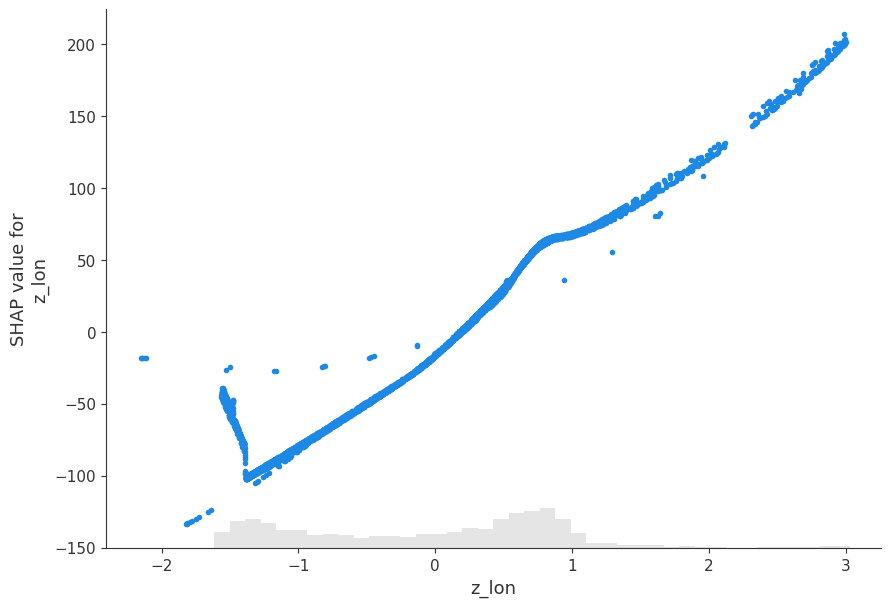

In [106]:
plt.figure(figsize=(10,7))
shap.plots.scatter(shap_values[:, "z_lon"], ax=plt.gca())

> As said before, there is a positive correlation between the value of the `z_lon` feature and its shapely values.

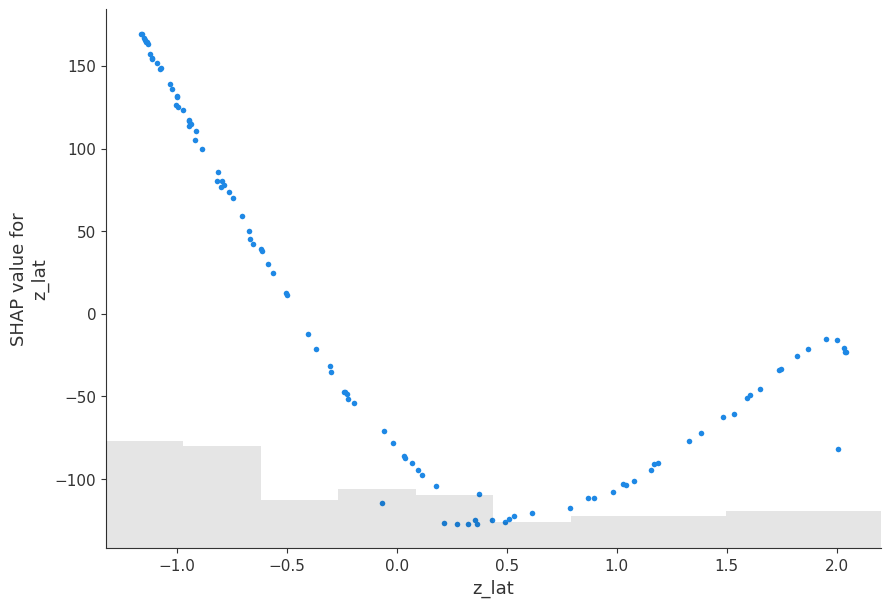

In [107]:
plt.figure(figsize=(10,7))
shap.plots.scatter(shap_values[:100, "z_lat"], ax=plt.gca())

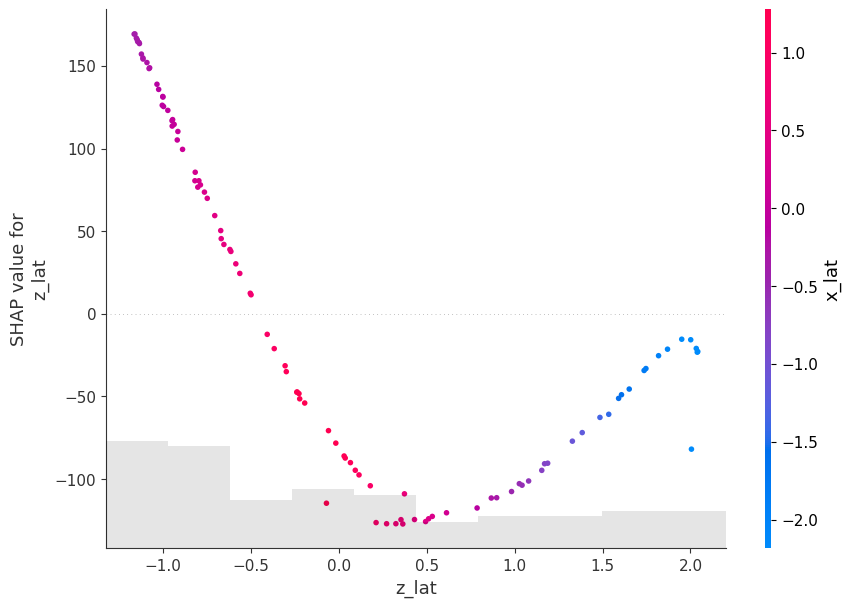

In [108]:
plt.figure(figsize=(10,7))
shap.plots.scatter(shap_values[:100,'z_lat'], color=shap_values[:100], ax=plt.gca())

In [109]:
df_shap = pd.DataFrame(shap_values.values, columns=feature_names)
df_input = pd.DataFrame(X_test_scaled, columns=feature_names)
corr = df_shap.corrwith(df_input["z_lat"])
print(corr)

x_lat          -0.384029
x_lon           0.464653
z_lat          -0.730412
z_lon           0.769942
altitude(km)   -0.206763
Earth_lat       0.566934
Earth_lon       0.453594
dtype: float64


> This is somehow analogous to the plots above, because it shows the correlation between how much that feature contributes and its raw value. If correlation > 0, larger feature value tends to push prediction upwards; if correlation < 0, it is the other way around.

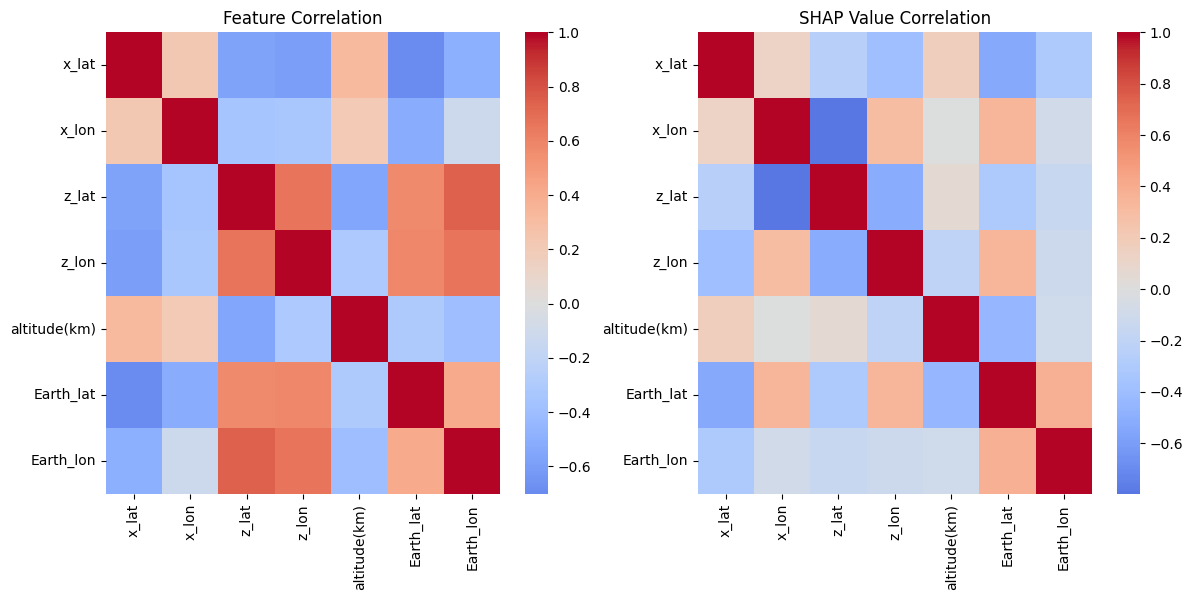

In [115]:
df_in = pd.DataFrame(X_test_scaled, columns=feature_names)
df_sh = pd.DataFrame(shap_values.values, columns=feature_names)

corr_input = df_in.corr()
corr_shap  = df_sh.corr()

fig, axs = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(corr_input, ax=axs[0], center=0, cmap='coolwarm').set_title('Feature Correlation')
sns.heatmap(corr_shap, ax=axs[1], center=0, cmap='coolwarm').set_title('SHAP Value Correlation')
plt.show()



---



> The "correlation of effects" matrix. It tells us whether certain features tend to move together in their influence. Counterintuitively, we shouldn't expect the same behavior of the correlation matrix of the raw input features [above](#corr). This is because the SHAP correlation matrix acts in *model space*, checking how the model's attributions move together across samples (how their influences on the prediction are coupled). It concerns *model's learned dependencies*. The feature correlation instead acts in the *data space*, measuring how the raw variables move together in the dataset (how they are structured). Indeed, they regard *dataset statistical dependencies.*
>
> They might diverge if the model is strongly non-linear, as in our case. Otherwise, our model would be acting in a linear fashion.

### Kolmogorov-Arnold Regressor

In [5]:
#!pip install pykan
from kan import *

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


In [7]:
model.plot()

Exception: model hasn't seen any data yet.